## Import libraries, methods and constants

In [1]:
import numpy as np
import json
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sn
import cv2
import matplotlib.pyplot as plt
from transformers import AutoModelForSemanticSegmentation
from sklearn.metrics import ConfusionMatrixDisplay
import os
from os import sys

c:\Users\kuian\.conda\envs\master\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from config import model_types, crops
from constants import weed_plants, weed_plants
from data_prepossessing import create_datasets_for_plants, get_labels
from data_visualization import use_one_channel

## Check if GPU is detected

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU
print(device)

cpu


## Analyse mean accuracy and mean IoU

In [4]:
def load_test_metrics_for_model(model_folder):
    eval_losses = {}
    eval_mean_ious = {}
    eval_mean_accuracies = {}
    eval_overall_accuracies = {}
    eval_per_category_ious = {}
    eval_per_category_accuracies = {}
    eval_runtimes = {}
    eval_samples_per_second = {}


    for model_type in model_types:
        eval_losses[model_type] = {}
        eval_mean_ious[model_type] = {}
        eval_mean_accuracies[model_type] = {}
        eval_overall_accuracies[model_type] = {}
        eval_per_category_ious[model_type] = {}
        eval_per_category_accuracies[model_type] = {}
        eval_runtimes[model_type] = {}
        eval_samples_per_second[model_type] = {}

        for crop in crops:
            with open('../' + model_folder + '/' + model_type + '/' + crop + '/test_metric.json', 'r') as file:
                data = json.load(file)
                eval_losses[model_type][crop] = data['eval_loss']
                eval_mean_ious[model_type][crop] = data['eval_mean_iou']
                eval_mean_accuracies[model_type][crop] = data['eval_mean_accuracy']
                eval_overall_accuracies[model_type][crop] = data['eval_overall_accuracy']
                eval_per_category_ious[model_type][crop] = data['eval_per_category_iou']
                eval_per_category_accuracies[model_type][crop] = data['eval_per_category_accuracy']
                eval_runtimes[model_type][crop] = data['eval_runtime']
                eval_samples_per_second[model_type][crop] = data['eval_samples_per_second']

    return eval_losses, eval_mean_ious, eval_mean_accuracies, eval_overall_accuracies, eval_per_category_ious, eval_per_category_accuracies, eval_runtimes, eval_samples_per_second

In [5]:
(
    s3_eval_losses,
    s3_eval_mean_ious,
    s3_eval_mean_accuracies,
    s3_eval_overall_accuracies,
    s3_eval_per_category_ious,
    s3_eval_per_category_accuracies,
    s3_eval_runtimes,
    s3_eval_samples_per_second,
) = load_test_metrics_for_model("segformer-models-3-patience")

(
    s5_eval_losses,
    s5_eval_mean_ious,
    s5_eval_mean_accuracies,
    s5_eval_overall_accuracies,
    s5_eval_per_category_ious,
    s5_eval_per_category_accuracies,
    s5_eval_runtimes,
    s5_eval_samples_per_second,
) = load_test_metrics_for_model("segformer-models-5-patience")

(
    u3_eval_losses,
    u3_eval_mean_ious,
    u3_eval_mean_accuracies,
    u3_eval_overall_accuracies,
    u3_eval_per_category_ious,
    u3_eval_per_category_accuracies,
    u3_eval_runtimes,
    u3_eval_samples_per_second,
) = load_test_metrics_for_model("upernet-swin-models-3-patience")

(
    u5_eval_losses,
    u5_eval_mean_ious,
    u5_eval_mean_accuracies,
    u5_eval_overall_accuracies,
    u5_eval_per_category_ious,
    u5_eval_per_category_accuracies,
    u5_eval_runtimes,
    u5_eval_samples_per_second,
) = load_test_metrics_for_model("upernet-swin-models-5-patience")

In [6]:
print(
    "Segformer 3 patience binary eval loss:",
    np.round(sum(s3_eval_losses["binary"].values()) / len(s3_eval_losses["binary"].values()), 4),
)
print(
    "Segformer 3 patience multiclass eval loss:",
    np.round(sum(s3_eval_losses["multiclass"].values()) / len(s3_eval_losses["multiclass"].values()), 4),
)
print(
    "Segformer 5 patience binary eval loss:",
    np.round(sum(s5_eval_losses["binary"].values()) / len(s5_eval_losses["binary"].values()), 4),
)
print(
    "Segformer 5 patience multiclass eval loss:",
    np.round(sum(s5_eval_losses["multiclass"].values()) / len(s5_eval_losses["multiclass"].values()), 4),
)
print(
    "Upernet Swin Transformer 3 patience binary eval loss:",
    np.round(sum(u3_eval_losses["binary"].values()) / len(u3_eval_losses["binary"].values()), 4),
)
print(
    "Upernet Swin Transformer 3 patience multiclass eval loss:",
    np.round(sum(u3_eval_losses["multiclass"].values()) / len(u3_eval_losses["multiclass"].values()), 4),
)
print(
    "Upernet Swin Transformer 5 patience binary eval loss:",
    np.round(sum(u5_eval_losses["binary"].values()) / len(u5_eval_losses["binary"].values()), 4),
)
print(
    "Upernet Swin Transformer 5 patience multiclass eval loss:",
    np.round(sum(u5_eval_losses["multiclass"].values()) / len(u5_eval_losses["multiclass"].values()), 4),
)

Segformer 3 patience binary eval loss: 0.0568
Segformer 3 patience multiclass eval loss: 0.0728
Segformer 5 patience binary eval loss: 0.0132
Segformer 5 patience multiclass eval loss: 0.0166
Upernet Swin Transformer 3 patience binary eval loss: 0.0176
Upernet Swin Transformer 3 patience multiclass eval loss: 0.0271
Upernet Swin Transformer 5 patience binary eval loss: 0.017
Upernet Swin Transformer 5 patience multiclass eval loss: 0.023


In [7]:
print(
    "Segformer 3 patience binary mean IoU:",
    np.round(sum(s3_eval_mean_ious["binary"].values()) / len(s3_eval_mean_ious["binary"].values()), 4),
)
print(
    "Segformer 3 patience multiclass mean IoU:",
    np.round(sum(s3_eval_mean_ious["multiclass"].values()) / len(s3_eval_mean_ious["multiclass"].values()), 4),
)
print(
    "Segformer 5 patience binary mean IoU:",
    np.round(sum(s5_eval_mean_ious["binary"].values()) / len(s5_eval_mean_ious["binary"].values()), 4),
)
print(
    "Segformer 5 patience multiclass mean IoU:",
    np.round(sum(s5_eval_mean_ious["multiclass"].values()) / len(s5_eval_mean_ious["multiclass"].values()), 4),
)
print(
    "Upernet Swin Transformer 3 patience binary mean IoU:",
    np.round(sum(u3_eval_mean_ious["binary"].values()) / len(u3_eval_mean_ious["binary"].values()), 4),
)
print(
    "Upernet Swin Transformer 3 patience multiclass mean IoU:",
    np.round(sum(u3_eval_mean_ious["multiclass"].values()) / len(u3_eval_mean_ious["multiclass"].values()), 4),
)
print(
    "Upernet Swin Transformer 5 patience binary mean IoU:",
    np.round(sum(u5_eval_mean_ious["binary"].values()) / len(u5_eval_mean_ious["binary"].values()), 4),
)
print(
    "Upernet Swin Transformer 5 patience multiclass mean IoU:",
    np.round(sum(u5_eval_mean_ious["multiclass"].values()) / len(u5_eval_mean_ious["multiclass"].values()), 4),
)

Segformer 3 patience binary mean IoU: 0.5785
Segformer 3 patience multiclass mean IoU: 0.3943
Segformer 5 patience binary mean IoU: 0.6631
Segformer 5 patience multiclass mean IoU: 0.5979
Upernet Swin Transformer 3 patience binary mean IoU: 0.7047
Upernet Swin Transformer 3 patience multiclass mean IoU: 0.6198
Upernet Swin Transformer 5 patience binary mean IoU: 0.7169
Upernet Swin Transformer 5 patience multiclass mean IoU: 0.6588


In [8]:
print(
    "Segformer 3 patience binary mean accuracy:",
    np.round(sum(s3_eval_mean_accuracies["binary"].values()) / len(s3_eval_mean_accuracies["binary"].values()), 4),
)
print(
    "Segformer 3 patience multiclass mean accuracy:",
    np.round(sum(s3_eval_mean_accuracies["multiclass"].values()) / len(s3_eval_mean_accuracies["multiclass"].values()), 4),
)
print(
    "Segformer 5 patience binary mean accuracy:",
    np.round(sum(s5_eval_mean_accuracies["binary"].values()) / len(s5_eval_mean_accuracies["binary"].values()), 4),
)
print(
    "Segformer 5 patience multiclass mean accuracy:",
    np.round(sum(s5_eval_mean_accuracies["multiclass"].values()) / len(s5_eval_mean_accuracies["multiclass"].values()), 4),
)
print(
    "Upernet Swin Transformer 3 patience binary mean accuracy:",
    np.round(sum(u3_eval_mean_accuracies["binary"].values()) / len(u3_eval_mean_accuracies["binary"].values()), 4),
)
print(
    "Upernet Swin Transformer 3 patience multiclass mean accuracy:",
    np.round(sum(u3_eval_mean_accuracies["multiclass"].values()) / len(u3_eval_mean_accuracies["multiclass"].values()), 4),
)
print(
    "Upernet Swin Transformer 5 patience binary mean accuracy:",
    np.round(sum(u5_eval_mean_accuracies["binary"].values()) / len(u5_eval_mean_accuracies["binary"].values()), 4),
)
print(
    "Upernet Swin Transformer 5 patience multiclass mean accuracy:",
    np.round(sum(u5_eval_mean_accuracies["multiclass"].values()) / len(u5_eval_mean_accuracies["multiclass"].values()), 4),
)

Segformer 3 patience binary mean accuracy: 0.623
Segformer 3 patience multiclass mean accuracy: 0.4448
Segformer 5 patience binary mean accuracy: 0.7006
Segformer 5 patience multiclass mean accuracy: 0.6603
Upernet Swin Transformer 3 patience binary mean accuracy: 0.7405
Upernet Swin Transformer 3 patience multiclass mean accuracy: 0.6908
Upernet Swin Transformer 5 patience binary mean accuracy: 0.7526
Upernet Swin Transformer 5 patience multiclass mean accuracy: 0.7251


In [9]:
print(
    "Segformer 3 patience binary overall accuracy:",
    np.round(sum(s3_eval_overall_accuracies["binary"].values()) / len(s3_eval_overall_accuracies["binary"].values()), 4),
)
print(
    "Segformer 3 patience multiclass overall accuracy:",
    np.round(sum(s3_eval_overall_accuracies["multiclass"].values()) / len(s3_eval_overall_accuracies["multiclass"].values()), 4),
)
print(
    "Segformer 5 patience binary overall accuracy:",
    np.round(sum(s5_eval_overall_accuracies["binary"].values()) / len(s5_eval_overall_accuracies["binary"].values()), 4),
)
print(
    "Segformer 5 patience multiclass overall accuracy:",
    np.round(sum(s5_eval_overall_accuracies["multiclass"].values()) / len(s5_eval_overall_accuracies["multiclass"].values()), 4),
)
print(
    "Upernet Swin Transformer 3 patience binary overall accuracy:",
    np.round(sum(u3_eval_overall_accuracies["binary"].values()) / len(u3_eval_overall_accuracies["binary"].values()), 4),
)
print(
    "Upernet Swin Transformer 3 patience multiclass overall accuracy:",
    np.round(sum(u3_eval_overall_accuracies["multiclass"].values()) / len(u3_eval_overall_accuracies["multiclass"].values()), 4),
)
print(
    "Upernet Swin Transformer 5 patience binary overall accuracy:",
    np.round(sum(u5_eval_overall_accuracies["binary"].values()) / len(u5_eval_overall_accuracies["binary"].values()), 4),
)
print(
    "Upernet Swin Transformer 5 patience multiclass overall accuracy:",
    np.round(sum(u5_eval_overall_accuracies["multiclass"].values()) / len(u5_eval_overall_accuracies["multiclass"].values()), 4),
)

Segformer 3 patience binary overall accuracy: 0.9925
Segformer 3 patience multiclass overall accuracy: 0.9887
Segformer 5 patience binary overall accuracy: 0.9959
Segformer 5 patience multiclass overall accuracy: 0.9951
Upernet Swin Transformer 3 patience binary overall accuracy: 0.9965
Upernet Swin Transformer 3 patience multiclass overall accuracy: 0.995
Upernet Swin Transformer 5 patience binary overall accuracy: 0.9966
Upernet Swin Transformer 5 patience multiclass overall accuracy: 0.9956


In [10]:
# print("Segformer 3 patience binary eval runtime:", sum(s3_eval_runtimes['binary'].values()) / len(s3_eval_runtimes['binary'].values()))
# print("Segformer 3 patience multiclass eval runtime:", sum(s3_eval_runtimes['multiclass'].values()) / len(s3_eval_runtimes['multiclass'].values()))
# print("Segformer 5 patience binary eval runtime:", sum(s5_eval_runtimes['binary'].values()) / len(s5_eval_runtimes['binary'].values()))
# print("Segformer 5 patience multiclass eval runtime:", sum(s5_eval_runtimes['multiclass'].values()) / len(s5_eval_runtimes['multiclass'].values()))
# print("Upernet Swin Transformer 3 patience binary eval runtime:", sum(u3_eval_runtimes['binary'].values()) / len(u3_eval_runtimes['binary'].values()))
# print("Upernet Swin Transformer 3 patience multiclass eval runtime:", sum(u3_eval_runtimes['multiclass'].values()) / len(u3_eval_runtimes['multiclass'].values()))
# print("Upernet Swin Transformer 5 patience binary eval runtime:", sum(u5_eval_runtimes['binary'].values()) / len(u5_eval_runtimes['binary'].values()))
# print("Upernet Swin Transformer 5 patience multiclass eval runtime:", sum(u5_eval_runtimes['multiclass'].values()) / len(u5_eval_runtimes['multiclass'].values()))

In [11]:
print(
    "Segformer 3 patience binary eval samples per second:",
    np.round(sum(s3_eval_samples_per_second["binary"].values()) / len(s3_eval_samples_per_second["binary"].values()), 4),
)
print(
    "Segformer 3 patience multiclass eval samples per second:",
    np.round(sum(s3_eval_samples_per_second["multiclass"].values()) / len(s3_eval_samples_per_second["multiclass"].values()), 4),
)
print(
    "Segformer 5 patience binary eval samples per second:",
    np.round(sum(s5_eval_samples_per_second["binary"].values()) / len(s5_eval_samples_per_second["binary"].values()), 4),
)
print(
    "Segformer 5 patience multiclass eval samples per second:",
    np.round(sum(s5_eval_samples_per_second["multiclass"].values()) / len(s5_eval_samples_per_second["multiclass"].values()), 4),
)
print(
    "Upernet Swin Transformer 3 patience binary eval samples per second:",
    np.round(sum(u3_eval_samples_per_second["binary"].values()) / len(u3_eval_samples_per_second["binary"].values()), 4),
)
print(
    "Upernet Swin Transformer 3 patience multiclass eval samples per second:",
    np.round(sum(u3_eval_samples_per_second["multiclass"].values()) / len(u3_eval_samples_per_second["multiclass"].values()), 4),
)
print(
    "Upernet Swin Transformer 5 patience binary eval samples per second:",
    np.round(sum(u5_eval_samples_per_second["binary"].values()) / len(u5_eval_samples_per_second["binary"].values()), 4),
)
print(
    "Upernet Swin Transformer 5 patience multiclass eval samples per second:",
    np.round(sum(u5_eval_samples_per_second["multiclass"].values()) / len(u5_eval_samples_per_second["multiclass"].values()), 4),
)

Segformer 3 patience binary eval samples per second: 1.2331
Segformer 3 patience multiclass eval samples per second: 1.2256
Segformer 5 patience binary eval samples per second: 1.2417
Segformer 5 patience multiclass eval samples per second: 1.2339
Upernet Swin Transformer 3 patience binary eval samples per second: 0.4949
Upernet Swin Transformer 3 patience multiclass eval samples per second: 0.3387
Upernet Swin Transformer 5 patience binary eval samples per second: 0.4867
Upernet Swin Transformer 5 patience multiclass eval samples per second: 0.336


In [12]:
# ToDO 
# per class metrics

## Analyze training and evaluation runtimes, the number of epochs and training and validation losses

In [13]:
def preprocess_model_performance_info_for_model(model_folder):
    train_runtimes = {}
    eval_runtimes = {}
    epochs = {}
    total_train_loss = {}
    train_losses = {}
    eval_losses = {}

    for model_type in model_types:
        train_runtimes[model_type] = {}
        eval_runtimes[model_type] = {}
        epochs[model_type] = {}
        total_train_loss[model_type] = {}
        train_losses[model_type] = {}
        eval_losses[model_type] = {}

        for crop in crops:
            with open('../' + model_folder + '/' + model_type + '/' + crop + '/log_history.json', 'r') as file:
                data = json.load(file)
                
                train_runtimes[model_type][crop] = data[-1]['train_runtime']
                epochs[model_type][crop] = data[-1]['epoch']

                eval_runtimes[model_type][crop] = []
                train_losses[model_type][crop] = []
                eval_losses[model_type][crop] = []
                for entry in data:
                    if 'eval_runtime' in entry.keys():
                        eval_runtimes[model_type][crop].append(entry['eval_runtime'])

                    if 'eval_loss' in entry.keys():
                        eval_losses[model_type][crop].append(entry['eval_loss'])

                    if 'loss' in entry.keys():
                        train_losses[model_type][crop].append(entry['loss'])

                    if 'train_loss' in entry.keys():
                        total_train_loss[model_type][crop] = entry['train_loss']

    return train_runtimes, eval_runtimes, epochs, total_train_loss, train_losses, eval_losses

In [14]:
def plot_bar_chart(data, title, store_filename = None):
    # Extract the labels and values for the 'binary' and 'multiclass' categories
    crops = list(data['binary'].keys())
    binary_values = [data['binary'][crop] for crop in crops]
    multiclass_values = [data['multiclass'][crop] for crop in crops]

    # Set the width of the bars
    bar_width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bar positions for each category
    x = range(len(crops))

    # Plot the 'binary' values
    plt.bar(x, binary_values, width=bar_width, label='Binary', align='center')

    # Plot the 'multiclass' values with an offset
    plt.bar([i + bar_width for i in x], multiclass_values, width=bar_width, label='Multiclass', align='center')

    plt.title(title)
    crop_labels = [crop.replace("_", " ") for crop in crops]
    plt.xticks([i + bar_width / 2 for i in x], crop_labels, rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()
    if store_filename:
        plt.savefig(store_filename)

In [15]:
def plot_heat_map(data, title):
    categories = list(data.keys())

    # Convert the data to a NumPy array
    heatmap_data = np.array([[data[category][crop] for crop in crops] for category in categories])

    fig, ax = plt.subplots(figsize=(10, 6))
    # Create the heatmap
    cax = ax.matshow(heatmap_data, cmap='viridis')

    # Add colorbar
    cbar = fig.colorbar(cax)

    # Set labels for the x and y axes
    labels = [crop.replace("_", " ") for crop in list(data['binary'].keys())]
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(categories)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(categories)

    # Show the values in each cell
    # for i in range(len(categories)):
    #     for j in range(len(items)):
    #         text = ax.text(j, i, f'{heatmap_data[i, j]:.2f}', ha='center', va='center', color='w', fontsize=8)  # Specify fontsize
    plt.title('Heatmap of Values for Different Categories and Items')
    plt.tight_layout()
    plt.show()

In [16]:
def compute_general_numeric_statistics(train_runtimes, eval_runtimes, epochs, train_losses, eval_losses):
    train_runtime_total = 0
    eval_runtime_total = 0

    train_runtime_per_model_type = {}
    eval_runtime_per_model_type = {}

    for model_type in model_types:
        train_runtime_per_model_type[model_type] = 0
        eval_runtime_per_model_type[model_type] = 0

        for crop in crops:
            train_runtime_total = train_runtime_total + train_runtimes[model_type][crop]
            eval_runtime_total = eval_runtime_total + sum(eval_runtimes[model_type][crop])

            train_runtime_per_model_type[model_type] = train_runtime_per_model_type[model_type] + train_runtimes[model_type][crop]
            eval_runtime_per_model_type[model_type] = eval_runtime_per_model_type[model_type] + sum(eval_runtimes[model_type][crop])
        
    print('Total training time in h: ' + str(train_runtime_total/60/60))
    print('Total evaluation time in h: ' + str(eval_runtime_total/60/60))

    print('Training time for binary models : ' + str(train_runtime_per_model_type['binary']/60/60))
    print('Training time for multiclass models : ' + str(train_runtime_per_model_type['multiclass']/60/60))
    print('Evaluation time for binary models : ' + str(eval_runtime_per_model_type['binary']/60/60))
    print('Evaluation time for multiclass models : ' + str(eval_runtime_per_model_type['multiclass']/60/60))

In [17]:
def plot_line_graph(data, title):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Loop through the categories and items to plot lines
    for category, item_data in data.items():
        for item, values in item_data.items():
            label = f'{category} - {item}'
            x = np.arange(len(values))
            ax.plot(x, values, label=label)

    ax.set_xlabel('Steps')
    ax.set_ylabel('Values')

    plt.title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

### Segformer models with early stopping patience of 5

In [18]:
(
    train_runtimes,
    eval_runtimes,
    epochs,
    total_train_loss,
    train_losses,
    eval_losses,
) = preprocess_model_performance_info_for_model("segformer-models-5-patience")

In [19]:
compute_general_numeric_statistics(train_runtimes, eval_runtimes, epochs, train_losses, eval_losses)

Total training time in h: 32.822256249999995
Total evaluation time in h: 15.772956805555557
Training time for binary models : 16.15026772222222
Training time for multiclass models : 16.671988527777778
Evaluation time for binary models : 7.741233527777779
Evaluation time for multiclass models : 8.031723277777779


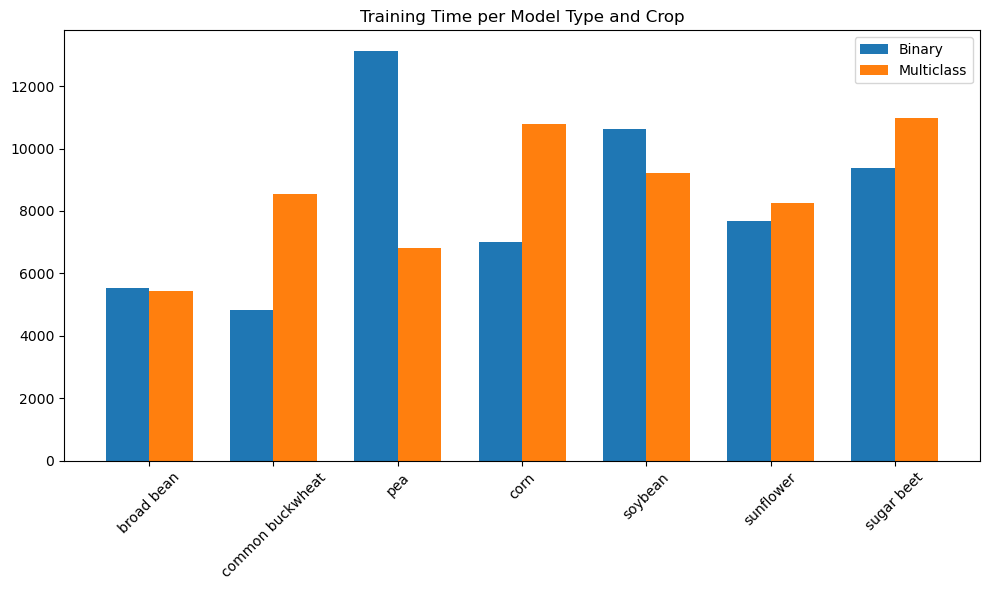

In [20]:
plot_bar_chart(train_runtimes, 'Training Time per Model Type and Crop')

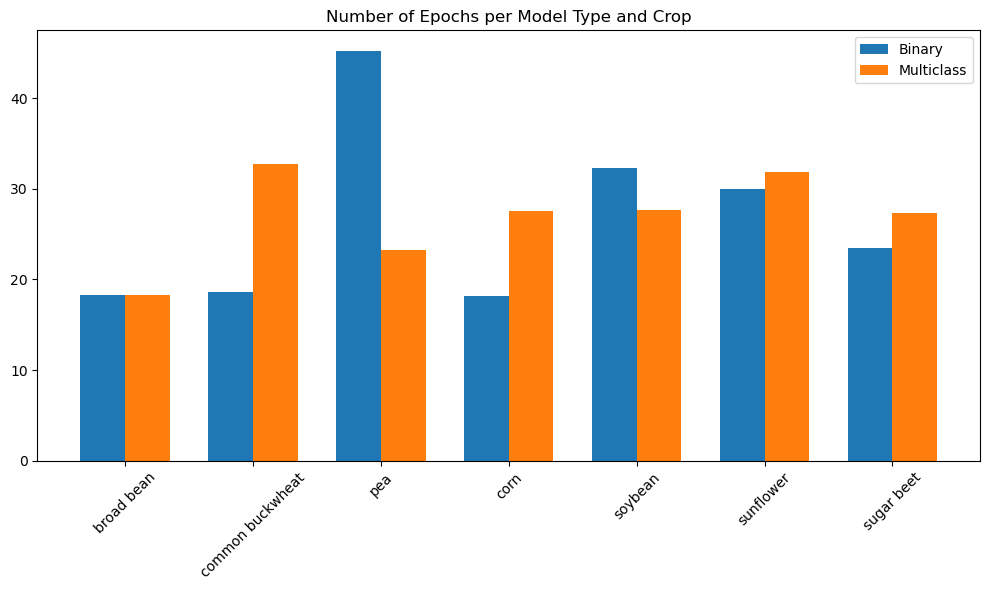

In [21]:
plot_bar_chart(epochs, 'Number of Epochs per Model Type and Crop', "xxx")

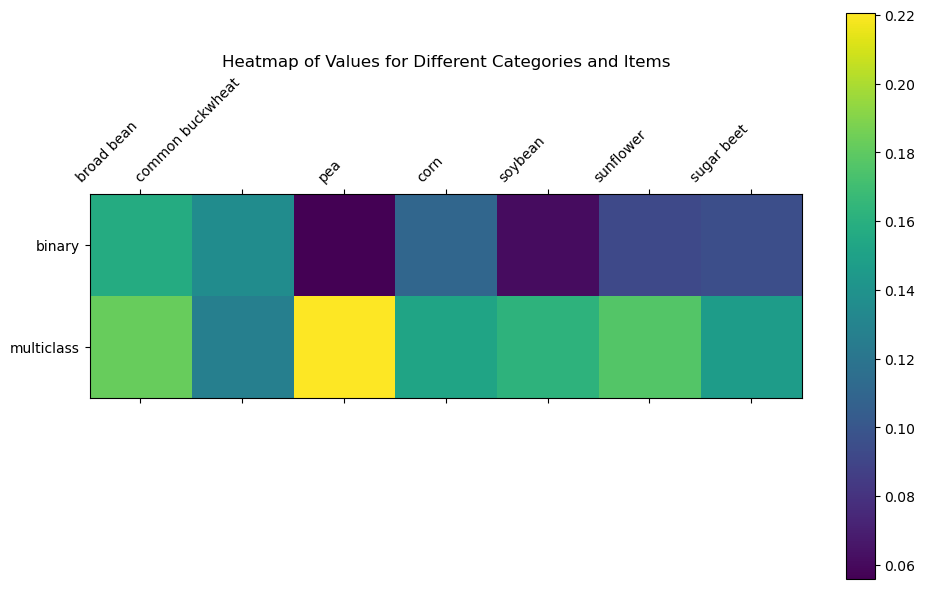

In [22]:
plot_heat_map(total_train_loss, 'Train Loss Heatmap per Model Type and Crop')

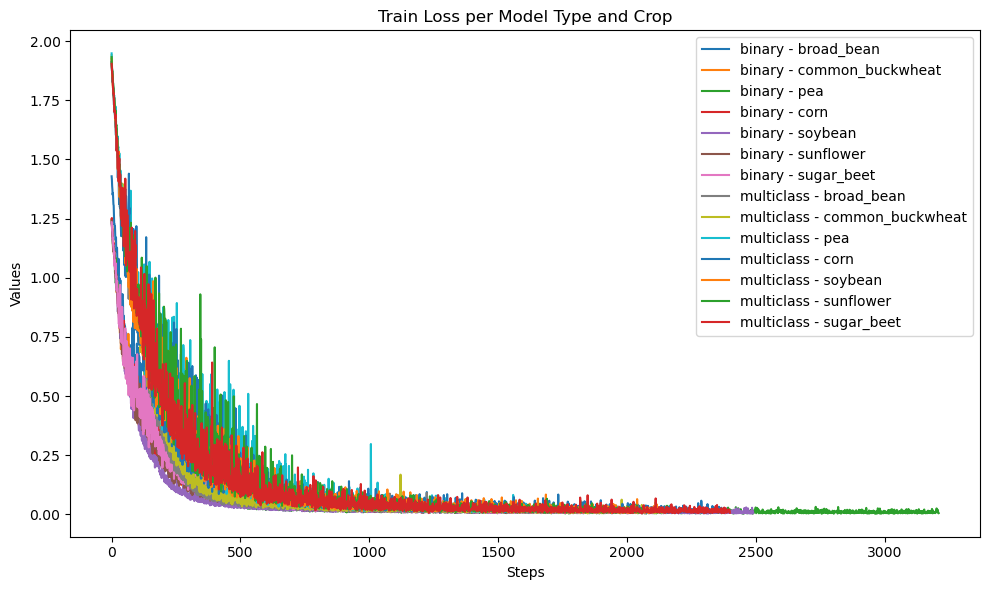

In [23]:
plot_line_graph(train_losses, 'Train Loss per Model Type and Crop')

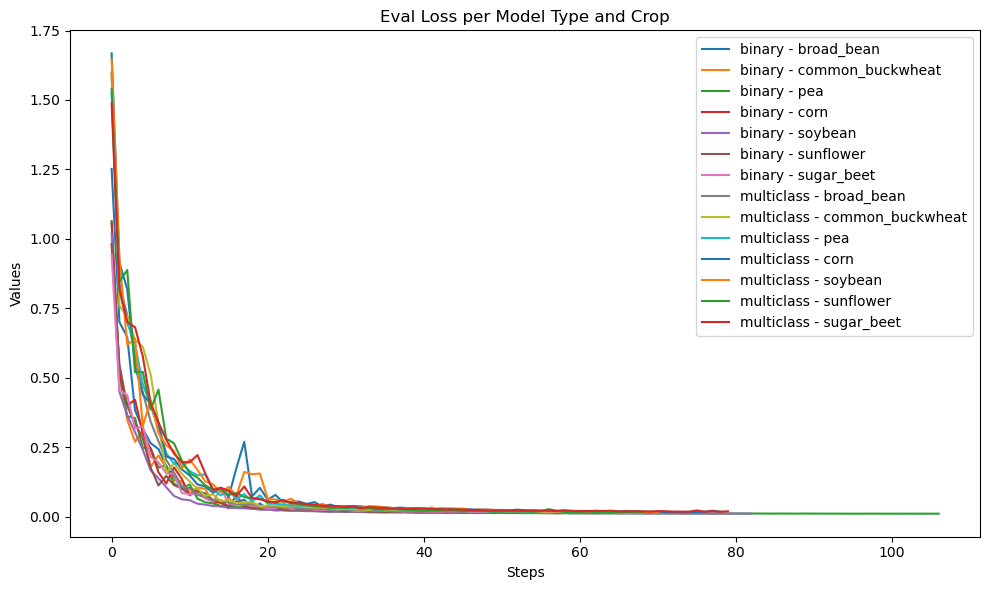

In [24]:
plot_line_graph(eval_losses, 'Eval Loss per Model Type and Crop')

### Upernet  models with early stopping patience of 5

In [25]:
train_runtimes, eval_runtimes, epochs, total_train_loss, train_losses, eval_losses = preprocess_model_performance_info_for_model('upernet-swin-models-5-patience')

In [26]:
compute_general_numeric_statistics(train_runtimes, eval_runtimes, epochs, train_losses, eval_losses)

Total training time in h: 28.419651
Total evaluation time in h: 14.288532583333334
Training time for binary models : 17.55273463888889
Training time for multiclass models : 10.866916361111112
Evaluation time for binary models : 8.810896916666668
Evaluation time for multiclass models : 5.477635666666668


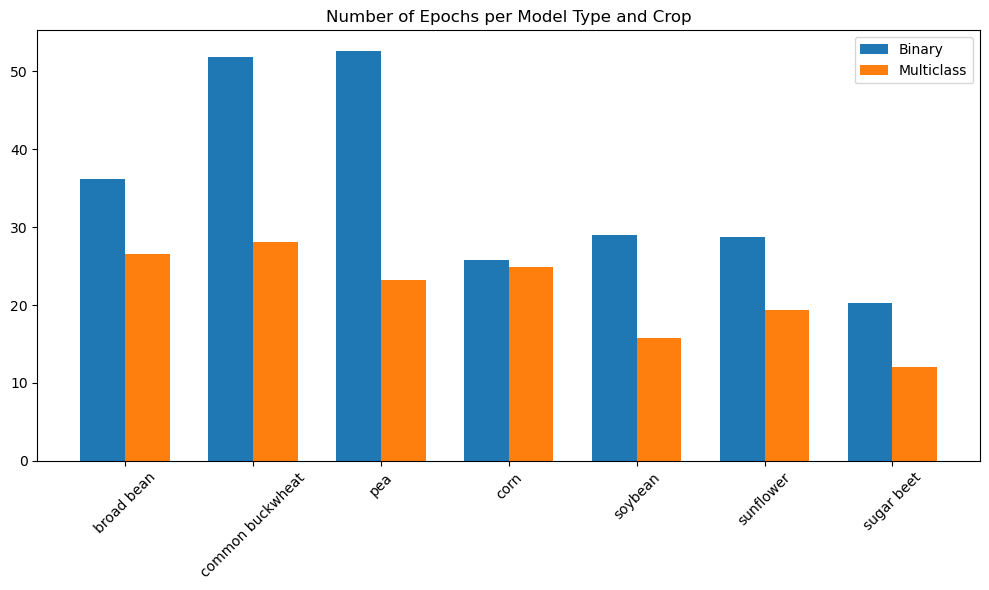

In [27]:
plot_bar_chart(epochs, 'Number of Epochs per Model Type and Crop')

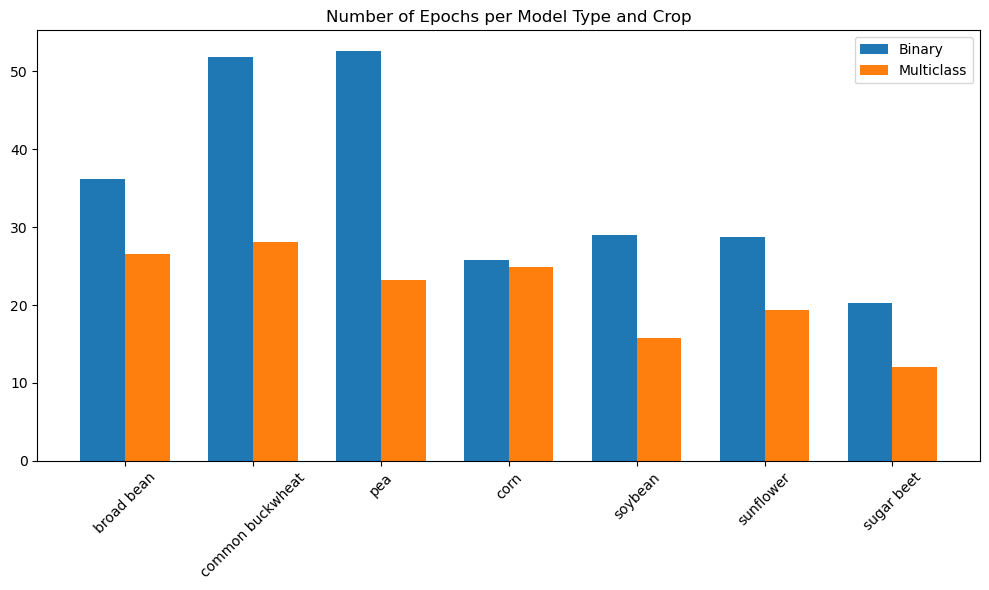

In [28]:
plot_bar_chart(epochs, 'Number of Epochs per Model Type and Crop')

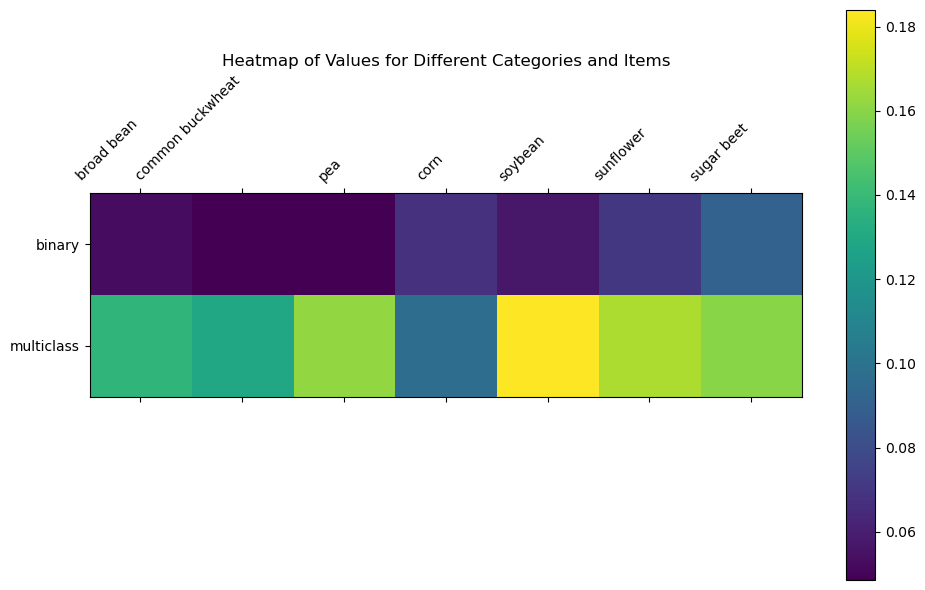

In [29]:
plot_heat_map(total_train_loss, 'Train Loss Heatmap per Model Type and Crop')

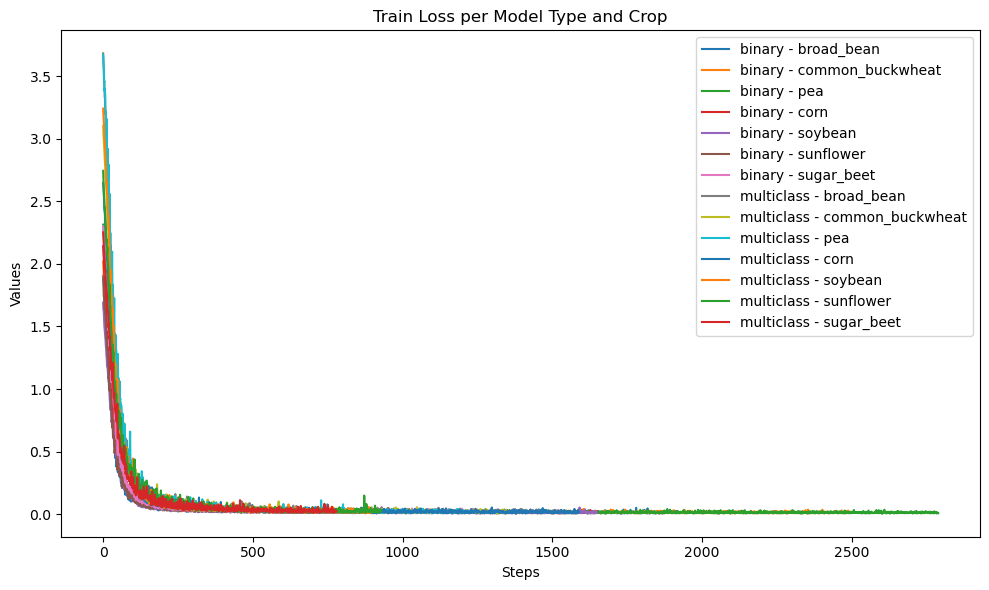

In [30]:
plot_line_graph(train_losses, 'Train Loss per Model Type and Crop')

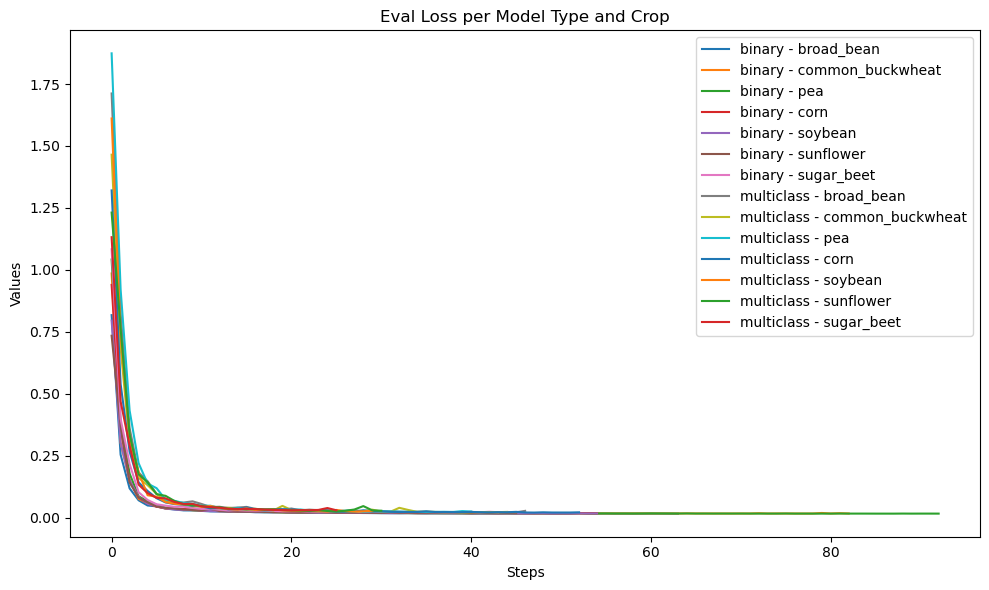

In [31]:
plot_line_graph(eval_losses, 'Eval Loss per Model Type and Crop')

## Predict test instances

In [32]:
segformer_checkpoint = "nvidia/mit-b0"
upernet_swin_checkpoint = "openmmlab/upernet-swin-tiny"

In [33]:
from transformers import AutoImageProcessor
segformer_image_processor = AutoImageProcessor.from_pretrained(segformer_checkpoint)
upernet_swin_image_processor = AutoImageProcessor.from_pretrained(upernet_swin_checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
c:\Users\kuian\.conda\envs\master\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [34]:
def get_test_data(crop, model_type):
    model_plant_names = [crop] + weed_plants
    train_ds, test_ds = create_datasets_for_plants(model_plant_names, model_type, crop)

    return test_ds

In [35]:
def get_model(crop, model_type, models_folder):
    id2label, label2id = get_labels(crop, model_type)

    checkpoint = models_folder + model_type + '/' + crop + '/'
    model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)
    model.to(device)

    return model

In [36]:
def pred_segm_mask(image, image_processor, device, model):
    encoding = image_processor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.to(device)

    outputs = model(pixel_values=pixel_values)

    logits = outputs.logits.cpu()

    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    pred_seg = upsampled_logits.argmax(dim=1)[0]
    return pred_seg.detach().cpu().numpy()

In [37]:
def compute_predictions(image_processor, models_folder):
    for crop in crops:
        test_ds = get_test_data(crop, 'binary')

        for model_type in model_types:
            model = get_model(crop, model_type, ".." + models_folder)

            for test_ds_entry in test_ds:
                folder_path = "../predictions/" + models_folder + "/" + model_type + "/" + crop + "/"
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)

                if not os.path.isfile(folder_path):
                    pred_seg = pred_segm_mask(test_ds_entry["image"], image_processor, device, model)
                    cv2.imwrite(folder_path + test_ds_entry["image_name"], pred_seg)

In [38]:
# compute_predictions(segformer_image_processor, '/segformer-models-3-patience/')
# compute_predictions(segformer_image_processor, '/segformer-models-5-patience/')
# compute_predictions(upernet_swin_image_processor, '/upernet-swin-models-3-patience/')
# compute_predictions(upernet_swin_image_processor, '/upernet-swin-models-5-patience/')

## Build confusion matrices

In [39]:
binary_base_conf_m = confusion_matrix([0,1,2,3], [0,1,2,3], labels=[0,1,2,3])

for trained_models_folder in ["segformer-models-3-patience", "segformer-models-5-patience", "upernet-swin-models-3-patience", "upernet-swin-models-5-patience"]:
    model_type = "binary"
    for crop in crops:
        conf_m_file_path = "../confusion_matrices/" + trained_models_folder + "/" + model_type + "_" + crop + "_conf_m.npy"
        if not os.path.exists(conf_m_file_path):
            test_ds = get_test_data(crop, model_type)
            cm = binary_base_conf_m

            for image_name in test_ds["image_name"]:
                y_pred = use_one_channel(cv2.imread("../predictions/" + trained_models_folder + "/" + model_type + "/" + crop + "/" + image_name)).flatten()
                y_true = use_one_channel(cv2.imread("../WE3DS/annotations_binary/" + crop + "/"  + image_name)).flatten()
                im_cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
                cm = cm + im_cm
            
            cm = cm - binary_base_conf_m
                
            with open(conf_m_file_path, "w") as file:
                np.save(conf_m_file_path, cm)

In [40]:
example_conf_m_1 = np.load("../confusion_matrices/segformer-models-3-patience/binary_broad_bean_conf_m.npy")
example_conf_m_1

array([[        0,    157825,      3103,     24038],
       [        0, 766074175,    210458,   1479130],
       [        0,    187667,   3919084,    112570],
       [        0,   1667905,     18136,   9557109]], dtype=int64)

In [41]:
multiclass_base_conf_m = confusion_matrix([0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7], labels=[0,1,2,3,4,5,6,7])

for trained_models_folder in ["segformer-models-3-patience", "segformer-models-5-patience", "upernet-swin-models-3-patience", "upernet-swin-models-5-patience"]:
    model_type = "multiclass"
    for crop in crops:
        conf_m_file_path = "../confusion_matrices/" + trained_models_folder + "/" + model_type + "_" + crop + "_conf_m.npy"
        if not os.path.exists(conf_m_file_path):
            test_ds = get_test_data(crop, model_type)
            cm = multiclass_base_conf_m

            for image_name in test_ds["image_name"]:
                y_pred = use_one_channel(cv2.imread("../predictions/" + trained_models_folder + "/" + model_type + "/" + crop + "/" + image_name)).flatten()
                y_true = use_one_channel(cv2.imread("../WE3DS/annotations_multiclass/" + crop + "/"  + image_name)).flatten()
                im_cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4,5,6,7])
                cm = cm + im_cm
            
            cm = cm - multiclass_base_conf_m
                
            with open(conf_m_file_path, "w") as file:
                np.save(conf_m_file_path, cm)

In [42]:
example_conf_m_2 = np.load("../confusion_matrices/segformer-models-3-patience/multiclass_broad_bean_conf_m.npy")
print(example_conf_m_2)

[[        0    153685      8096      5623      7831      2703      7028
          0]
 [        0 766375265    220419    329568    475395    204231    158885
          0]
 [        0     74679   4122363         0     20933      1346         0
          0]
 [        0    410374       516   2279310    282388      3103      4598
          0]
 [        0    377569      1363     34638   3094635         0         0
          0]
 [        0     79269         0       148      3564   2935466        66
          0]
 [        0    415246         0     16636       485         0   1086451
          0]
 [        0    132922         0     54041      1494     27391      1477
          0]]


In [43]:
example_conf_m_2 = np.array(
    [
        [12, 3, 4, 1, 2, 0, 0, 1],
        [1, 22, 0, 1, 0, 1, 0, 0],
        [2, 3, 10, 4, 1, 1, 1, 0],
        [0, 1, 2, 8, 1, 0, 0, 2],
        [1, 0, 0, 0, 9, 1, 1, 0],
        [0, 0, 1, 0, 0, 7, 2, 0],
        [0, 0, 0, 0, 0, 2, 6, 0],
        [1, 0, 0, 2, 0, 0, 0, 9],
    ]
)
print(example_conf_m_2)

# Combine the "weed 1" to "weed 5" counts into a single "weed" class
reduced_confusion_matrix_2 = np.zeros((4, 4))  # Initialize a 4x4 matrix for the reduced classes

# Copy void, soil, and crop counts from confusion_matrix_2 to reduced_confusion_matrix_2
reduced_confusion_matrix_2[:3, :3] = example_conf_m_2[:3, :3]

# Sum the counts of "weed 1" to "weed 5" and put them in the "weed" class
weed_indices = [3, 4, 5, 6, 7]
reduced_confusion_matrix_2[3, 3] = sum([sum(i) for i in example_conf_m_2[3:, 3:]])
for i in range(3):
    reduced_confusion_matrix_2[3, i] = sum(example_conf_m_2[3:, i])
    reduced_confusion_matrix_2[i, 3] = sum(example_conf_m_2[i, 3:])

# Print the reduced confusion matrix
print(reduced_confusion_matrix_2)

[[12  3  4  1  2  0  0  1]
 [ 1 22  0  1  0  1  0  0]
 [ 2  3 10  4  1  1  1  0]
 [ 0  1  2  8  1  0  0  2]
 [ 1  0  0  0  9  1  1  0]
 [ 0  0  1  0  0  7  2  0]
 [ 0  0  0  0  0  2  6  0]
 [ 1  0  0  2  0  0  0  9]]
[[12.  3.  4.  4.]
 [ 1. 22.  0.  2.]
 [ 2.  3. 10.  7.]
 [ 2.  1.  3. 50.]]


In [44]:
example_conf_m_2 = np.load("../confusion_matrices/segformer-models-3-patience/multiclass_broad_bean_conf_m.npy")
print(example_conf_m_2)

# Combine the "weed 1" to "weed 5" counts into a single "weed" class
reduced_confusion_matrix_2 = np.zeros((4, 4))  # Initialize a 4x4 matrix for the reduced classes

# Copy void, soil, and crop counts from confusion_matrix_2 to reduced_confusion_matrix_2
reduced_confusion_matrix_2[:3, :3] = example_conf_m_2[:3, :3]

# Sum the counts of "weed 1" to "weed 5" and put them in the "weed" class
weed_indices = [3, 4, 5, 6, 7]
reduced_confusion_matrix_2[3, 3] = sum([sum(i) for i in example_conf_m_2[3:, 3:]])
for i in range(3):
    reduced_confusion_matrix_2[3, i] = sum(example_conf_m_2[3:, i])
    reduced_confusion_matrix_2[i, 3] = sum(example_conf_m_2[i, 3:])

# Print the reduced confusion matrix
print(reduced_confusion_matrix_2.astype(int))

[[        0    153685      8096      5623      7831      2703      7028
          0]
 [        0 766375265    220419    329568    475395    204231    158885
          0]
 [        0     74679   4122363         0     20933      1346         0
          0]
 [        0    410374       516   2279310    282388      3103      4598
          0]
 [        0    377569      1363     34638   3094635         0         0
          0]
 [        0     79269         0       148      3564   2935466        66
          0]
 [        0    415246         0     16636       485         0   1086451
          0]
 [        0    132922         0     54041      1494     27391      1477
          0]]
[[        0    153685      8096     23185]
 [        0 766375265    220419   1168079]
 [        0     74679   4122363     22279]
 [        0   1415380      1879   9825891]]


In [45]:
example_conf_m_1 = np.load("../confusion_matrices/segformer-models-3-patience/binary_broad_bean_conf_m.npy")
example_conf_m_1

array([[        0,    157825,      3103,     24038],
       [        0, 766074175,    210458,   1479130],
       [        0,    187667,   3919084,    112570],
       [        0,   1667905,     18136,   9557109]], dtype=int64)

In [46]:
print(sum([sum(i) for i in example_conf_m_1]))
print(sum([sum(i) for i in example_conf_m_2]))

783411200
783411200


In [47]:
np.set_printoptions(suppress=True)

In [48]:
display_labels = ["void", "soil", "crop", "weed"]

In [49]:
def confusion_matrix_to_percentages(matrix):
    # Calculate row sums (true instances in each class)
    row_sums = matrix.sum(axis=1, keepdims=True)
    
    # Calculate the percentages by dividing each cell by the row sums
    percentages = matrix / row_sums * 100
    
    return percentages

In [50]:
def compute_and_visualize_confusion_matrices(models_folder):
    total_binary_conf_m = np.zeros((4, 4))
    total_multiclass_conf_m = np.zeros((4, 4))
    for crop in crops:
        binary_conf_m = np.load(models_folder + "binary_" + crop + "_conf_m.npy")
        multiclass_full_conf_m = np.load(models_folder + "multiclass_" + crop + "_conf_m.npy")

        # Combine the "weed 1" to "weed 5" counts into a single "weed" class
        reduced_multiclass_conf_m = np.zeros((4, 4))  # Initialize a 4x4 matrix for the reduced classes

        # Copy void, soil, and crop counts from confusion_matrix_2 to reduced_confusion_matrix_2
        reduced_multiclass_conf_m[:3, :3] = multiclass_full_conf_m[:3, :3]

        # Sum the counts of "weed 1" to "weed 5" and put them in the "weed" class
        reduced_multiclass_conf_m[3, 3] = sum([sum(i) for i in multiclass_full_conf_m[3:, 3:]])
        for i in range(3):
            reduced_multiclass_conf_m[3, i] = sum(multiclass_full_conf_m[3:, i])
            reduced_multiclass_conf_m[i, 3] = sum(multiclass_full_conf_m[i, 3:])

        total_binary_conf_m = np.int64(total_binary_conf_m + binary_conf_m)
        total_multiclass_conf_m = np.int64(total_multiclass_conf_m + reduced_multiclass_conf_m)

        # Print the reduced confusion matrix
        print("Crop: " + crop)
        print("Multiclass absolute confusion matrix: ")
        print(reduced_multiclass_conf_m.astype(int))
        print("Binary absolute confusion matrix: ")
        print(binary_conf_m)

        multiclass_perc_conf_m = np.round(confusion_matrix_to_percentages(reduced_multiclass_conf_m.astype(int)), 2)
        binary_perc_conf_m = np.round(confusion_matrix_to_percentages(binary_conf_m), 2)

        print("Multiclass percentage confusion matrix: ")
        print(multiclass_perc_conf_m)
        print("Binary percentage confusion matrix: ")
        print(binary_perc_conf_m)

        multiclass_plot = ConfusionMatrixDisplay(confusion_matrix=multiclass_perc_conf_m, display_labels=display_labels)
        multiclass_plot.plot()
        multiclass_plot.ax_.set_title("Multiclass")
        plt.savefig(models_folder + "images/" + "perc_multiclass_" + crop + "_conf_m.png", bbox_inches='tight')

        binary_plot = ConfusionMatrixDisplay(confusion_matrix=binary_perc_conf_m, display_labels=display_labels)
        binary_plot.plot()
        binary_plot.ax_.set_title("Binary")
        plt.savefig(models_folder + "images/" + "perc_binary_" + crop + "_conf_m.png", bbox_inches='tight')

    print("Total binary absolute confusion matrix: ")
    print(total_binary_conf_m.astype(int))
    print("Total multiclass absolute confusion matrix: ")
    print(total_multiclass_conf_m.astype(int))

    multiclass_perc_conf_m = np.round(confusion_matrix_to_percentages(total_multiclass_conf_m.astype(int)), 2)
    binary_perc_conf_m = np.round(confusion_matrix_to_percentages(total_binary_conf_m), 2)

    print("Total multiclass percentage confusion matrix: ")
    print(multiclass_perc_conf_m)
    print("Total binary percentage confusion matrix: ")
    print(binary_perc_conf_m)

    multiclass_plot = ConfusionMatrixDisplay(confusion_matrix=multiclass_perc_conf_m, display_labels=display_labels)
    multiclass_plot.plot(cmap="magma")
    multiclass_plot.ax_.set_title("Multiclass")
    plt.savefig(models_folder + "images/" + "perc_multiclass_total_conf_m.png", bbox_inches='tight')

    binary_plot = ConfusionMatrixDisplay(confusion_matrix=binary_perc_conf_m, display_labels=display_labels)
    binary_plot.plot(cmap="magma")
    binary_plot.ax_.set_title("Binary")
    plt.savefig(models_folder + "images/" + "perc_binary_total_conf_m.png", bbox_inches='tight')


Crop: broad_bean
Multiclass absolute confusion matrix: 
[[        0    153685      8096     23185]
 [        0 766375265    220419   1168079]
 [        0     74679   4122363     22279]
 [        0   1415380      1879   9825891]]
Binary absolute confusion matrix: 
[[        0    157825      3103     24038]
 [        0 766074175    210458   1479130]
 [        0    187667   3919084    112570]
 [        0   1667905     18136   9557109]]
Multiclass percentage confusion matrix: 
[[ 0.   83.09  4.38 12.53]
 [ 0.   99.82  0.03  0.15]
 [ 0.    1.77 97.7   0.53]
 [ 0.   12.59  0.02 87.39]]
Binary percentage confusion matrix: 
[[ 0.   85.33  1.68 13.  ]
 [ 0.   99.78  0.03  0.19]
 [ 0.    4.45 92.88  2.67]
 [ 0.   14.83  0.16 85.  ]]
Crop: common_buckwheat
Multiclass absolute confusion matrix: 
[[        0    196365       157       973]
 [        0 703330347     66016    296970]
 [        0    751734   1139094    489746]
 [        0   7172153     61594   4011651]]
Binary absolute confusion matrix

Crop: pea
Multiclass absolute confusion matrix: 
[[        0    157883      1092      8674]
 [        0 765592444    146643   1039186]
 [        0    492721   1020449     48158]
 [        0   2610915    186107   8446128]]
Binary absolute confusion matrix: 
[[        0    163292         0      4357]
 [        0 765846713     54491    877069]
 [        0    698390    345736    517202]
 [        0   3527356    136742   7579052]]
Multiclass percentage confusion matrix: 
[[ 0.   94.17  0.65  5.17]
 [ 0.   99.85  0.02  0.14]
 [ 0.   31.56 65.36  3.08]
 [ 0.   23.22  1.66 75.12]]
Binary percentage confusion matrix: 
[[ 0.   97.4   0.    2.6 ]
 [ 0.   99.88  0.01  0.11]
 [ 0.   44.73 22.14 33.13]
 [ 0.   31.37  1.22 67.41]]
Crop: corn
Multiclass absolute confusion matrix: 
[[        0    216087     10825     77160]
 [        0 924902679    286237   1241183]
 [        0    461187   5362213     36174]
 [        0   1832422     49265  10010968]]
Binary absolute confusion matrix: 
[[        0    2

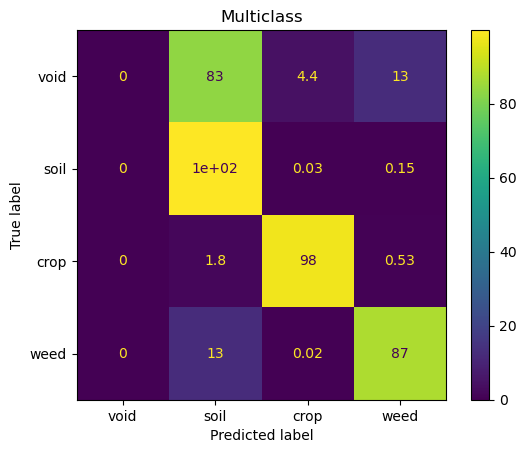

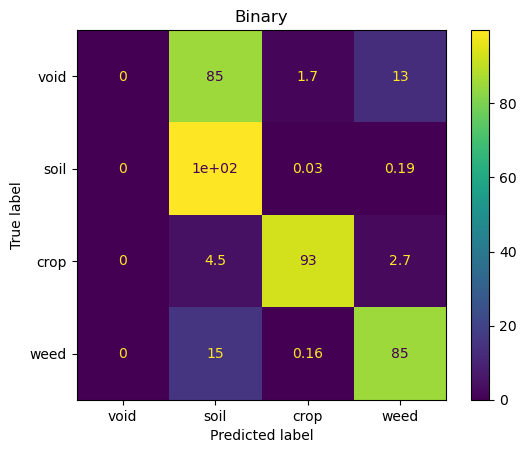

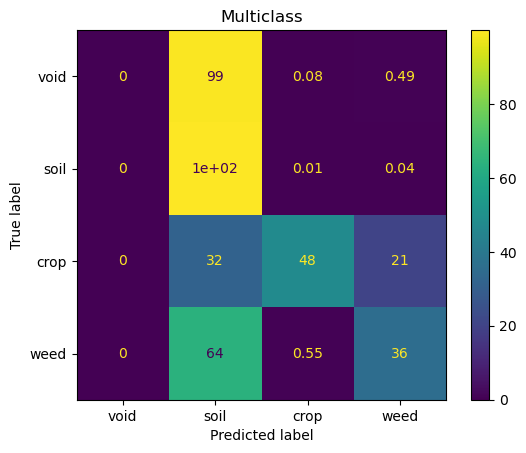

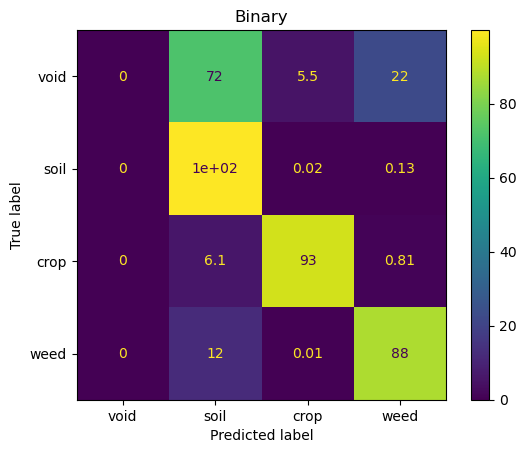

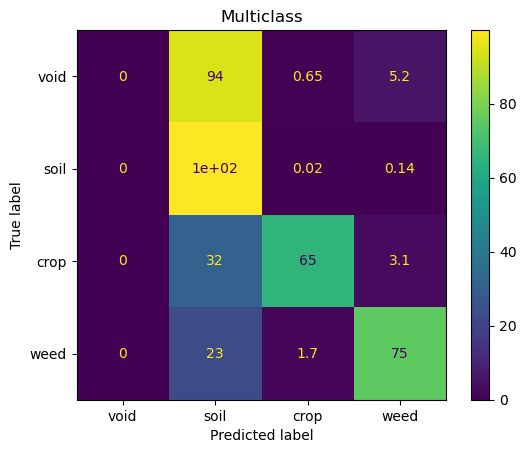

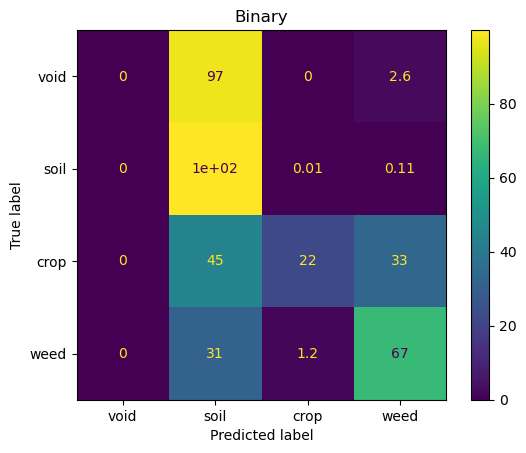

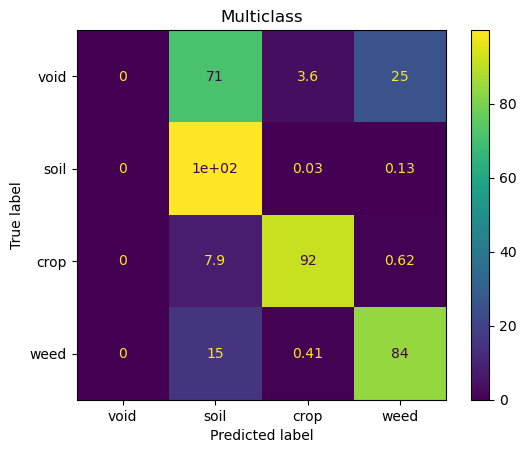

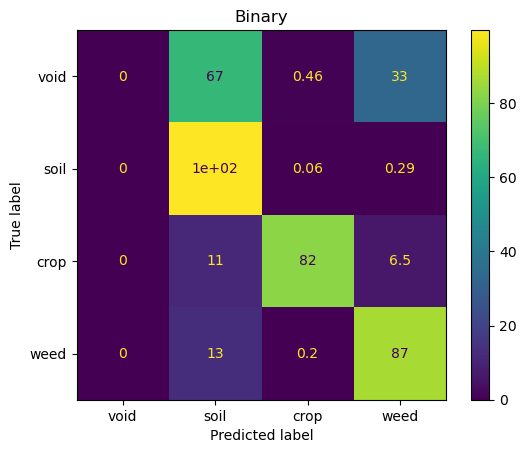

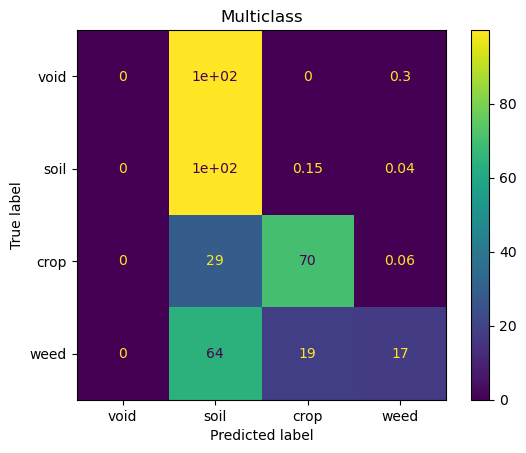

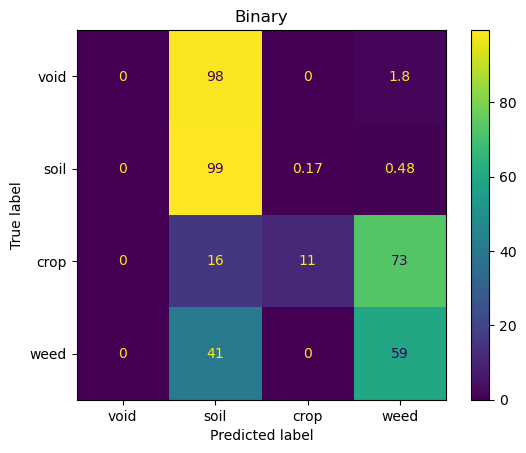

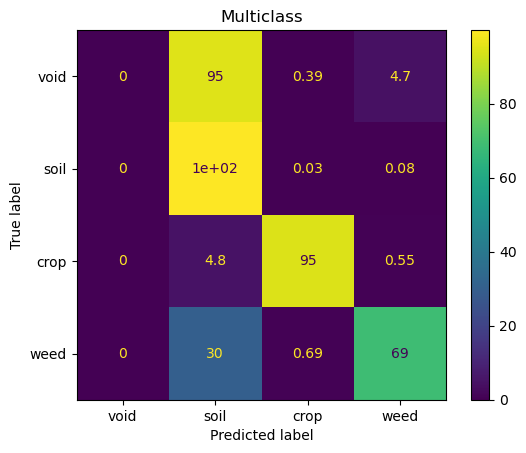

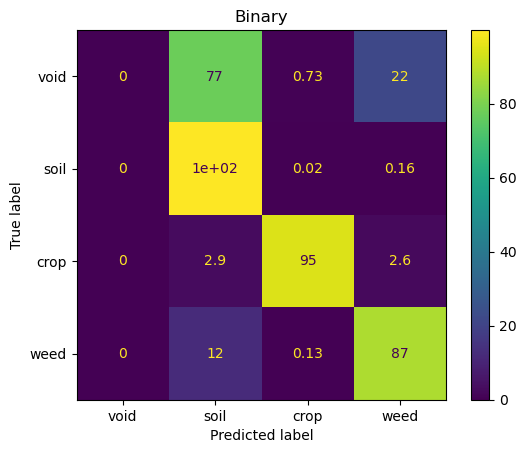

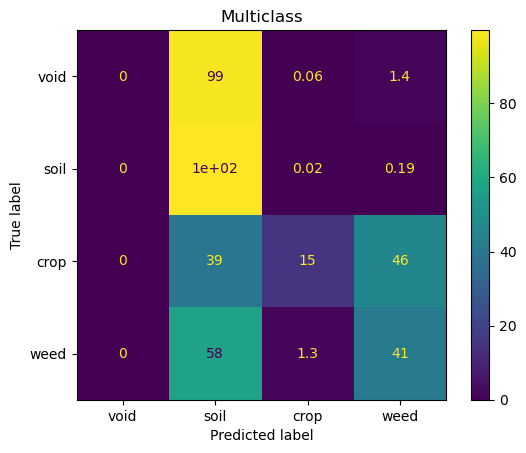

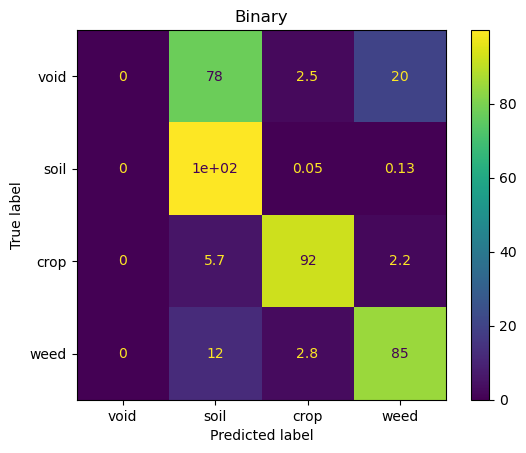

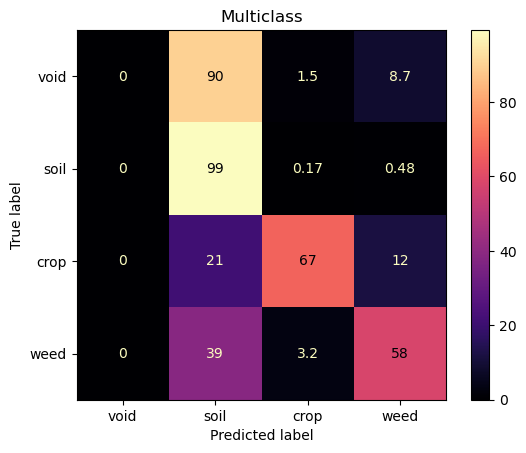

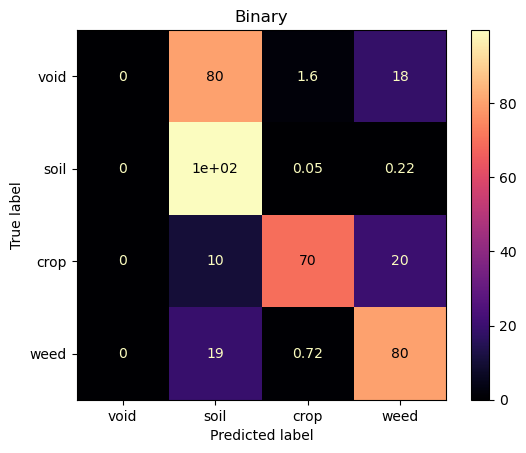

In [51]:
compute_and_visualize_confusion_matrices("../confusion_matrices/segformer-models-3-patience/")

Crop: broad_bean
Multiclass absolute confusion matrix: 
[[        0    153693      8060     23213]
 [        0 766382102    215051   1166610]
 [        0     77146   4120592     21583]
 [        0   1415875      1790   9825485]]
Binary absolute confusion matrix: 
[[        0    133922      6835     44209]
 [        0 766155592    236155   1372016]
 [        0     92591   4052341     74389]
 [        0   1183202      3870  10056078]]
Multiclass percentage confusion matrix: 
[[ 0.   83.09  4.36 12.55]
 [ 0.   99.82  0.03  0.15]
 [ 0.    1.83 97.66  0.51]
 [ 0.   12.59  0.02 87.39]]
Binary percentage confusion matrix: 
[[ 0.   72.4   3.7  23.9 ]
 [ 0.   99.79  0.03  0.18]
 [ 0.    2.19 96.04  1.76]
 [ 0.   10.52  0.03 89.44]]
Crop: common_buckwheat
Multiclass absolute confusion matrix: 
[[        0    158223      4565     34707]
 [        0 702605859    145410    942064]
 [        0    134862   2235040     10672]
 [        0   1513280      9592   9722526]]
Binary absolute confusion matrix

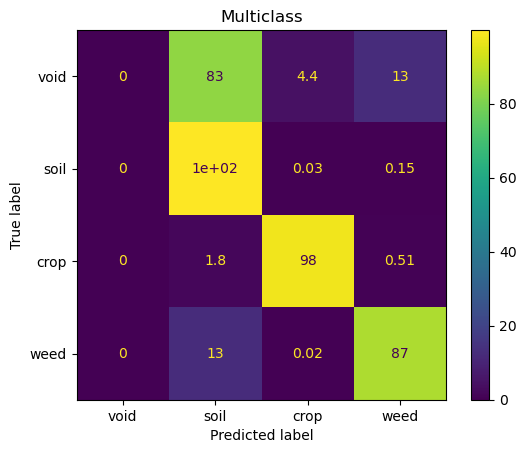

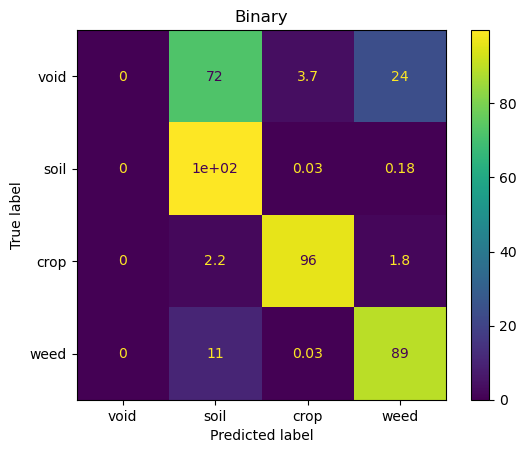

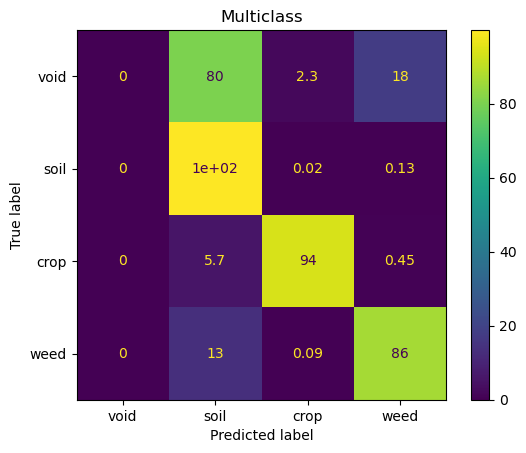

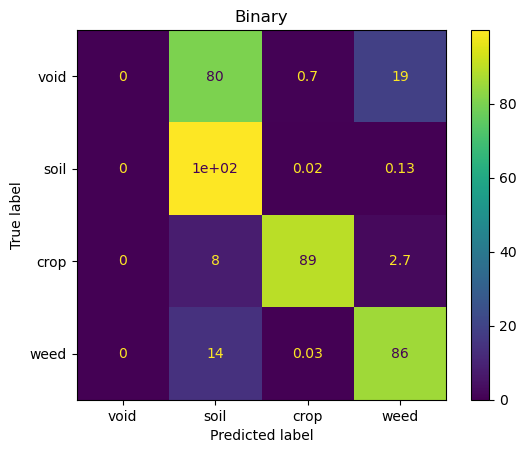

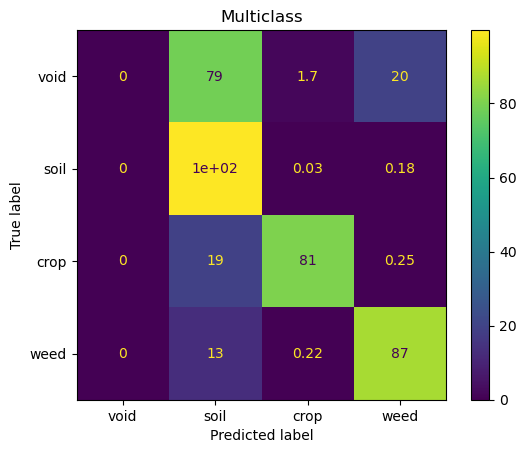

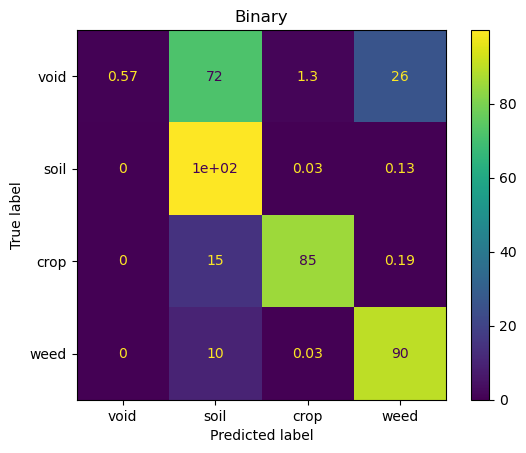

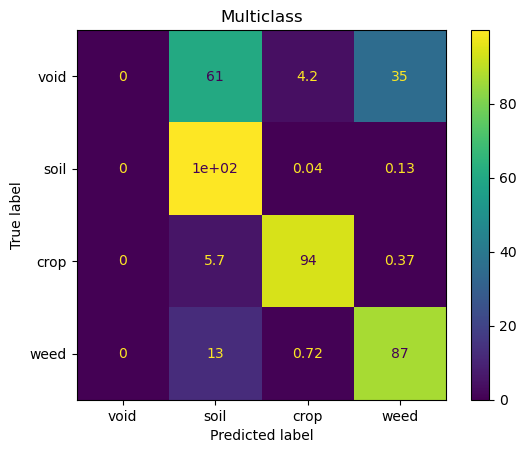

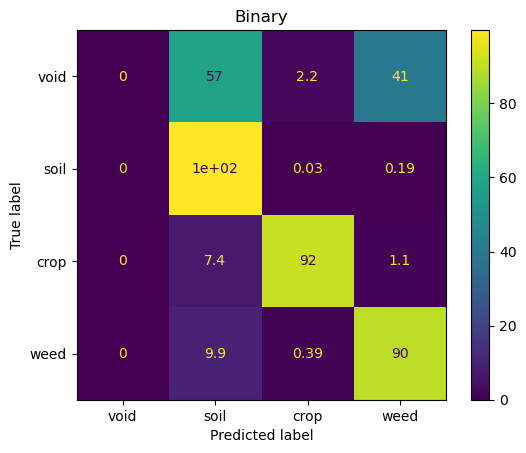

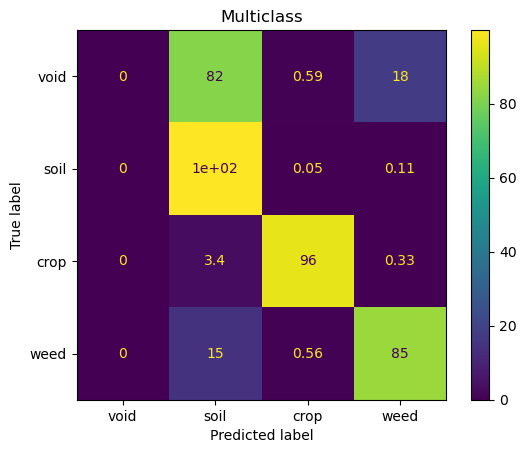

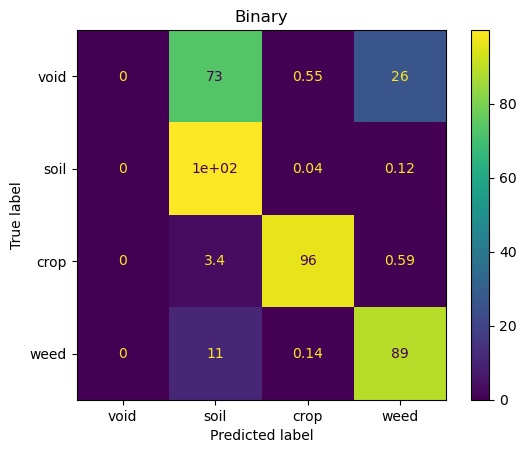

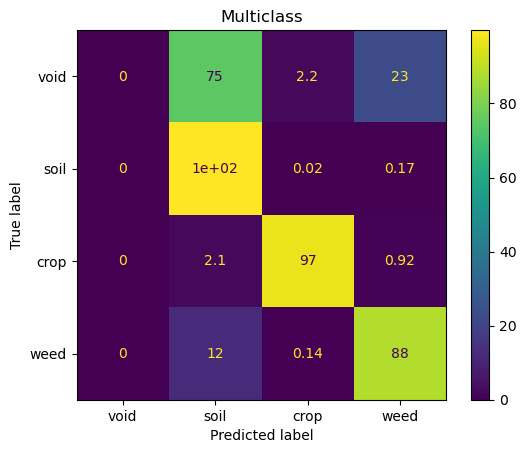

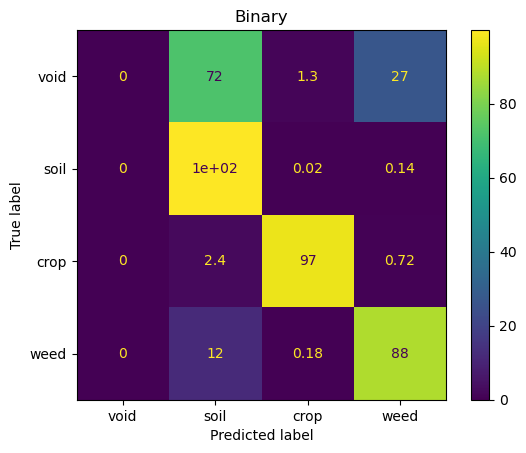

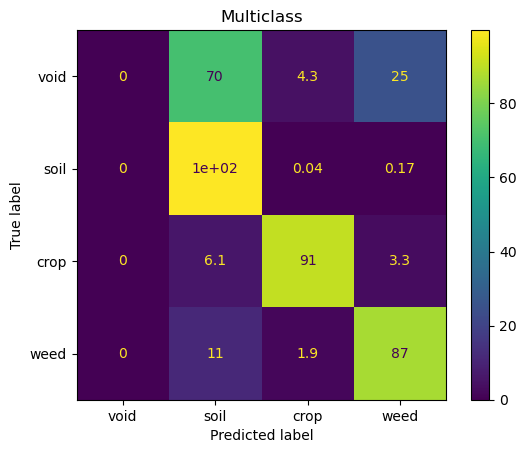

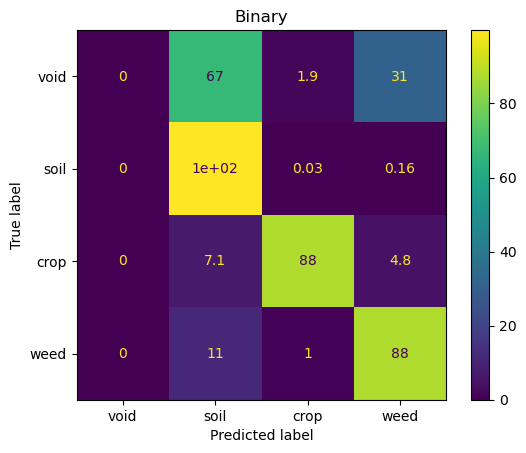

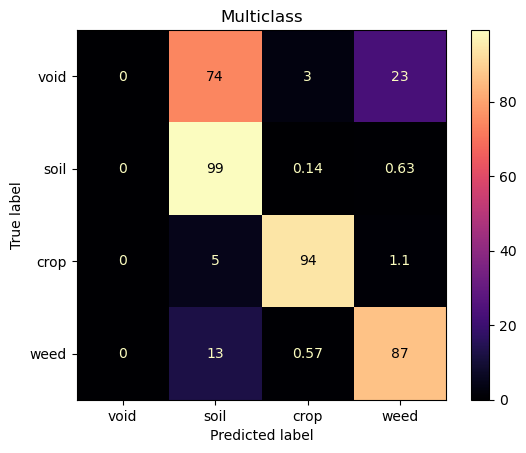

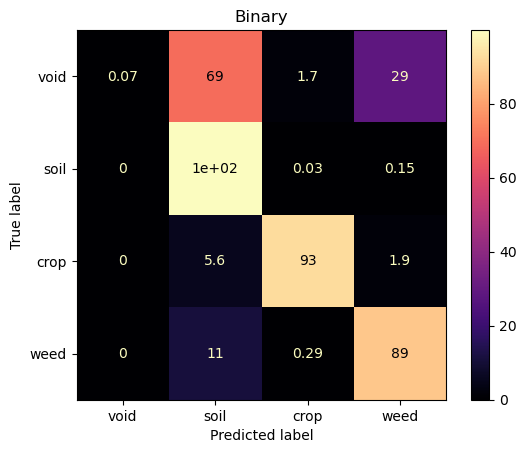

In [52]:
compute_and_visualize_confusion_matrices("../confusion_matrices/segformer-models-5-patience/")

Crop: broad_bean
Multiclass absolute confusion matrix: 
[[        0    151096      7213     26657]
 [        0 766370299    277318   1116146]
 [        0     54066   4135924     29331]
 [        0   1634136     73295   9535719]]
Binary absolute confusion matrix: 
[[    42358    110764      6721     25123]
 [    17796 766659583    145532    940852]
 [     1261     80298   4111283     26479]
 [     4099   1047197      1156  10190698]]
Multiclass percentage confusion matrix: 
[[ 0.   81.69  3.9  14.41]
 [ 0.   99.82  0.04  0.15]
 [ 0.    1.28 98.02  0.7 ]
 [ 0.   14.53  0.65 84.81]]
Binary percentage confusion matrix: 
[[22.9  59.88  3.63 13.58]
 [ 0.   99.86  0.02  0.12]
 [ 0.03  1.9  97.44  0.63]
 [ 0.04  9.31  0.01 90.64]]
Crop: common_buckwheat
Multiclass absolute confusion matrix: 
[[     5993    164278      1699     25525]
 [     1120 702639554    110715    941944]
 [      522    154492   2215714      9846]
 [        0   1636798     13497   9595103]]
Binary absolute confusion matrix

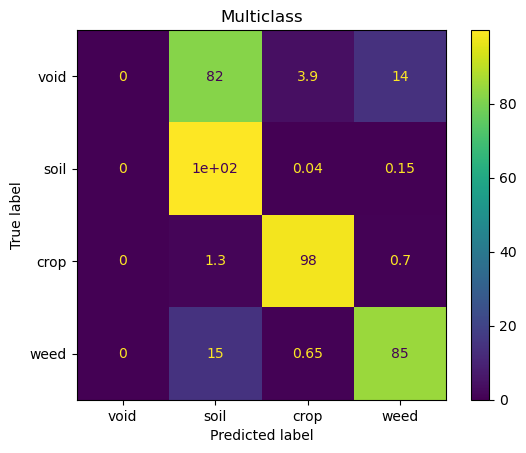

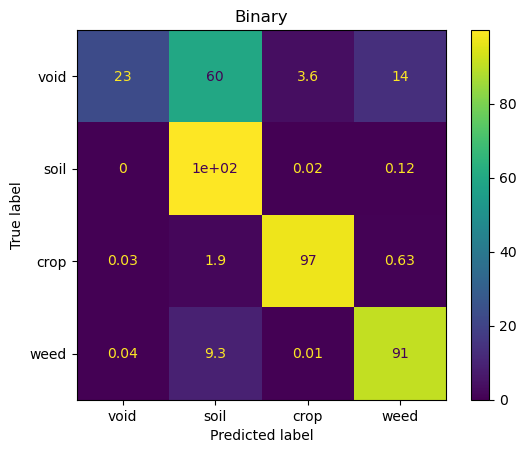

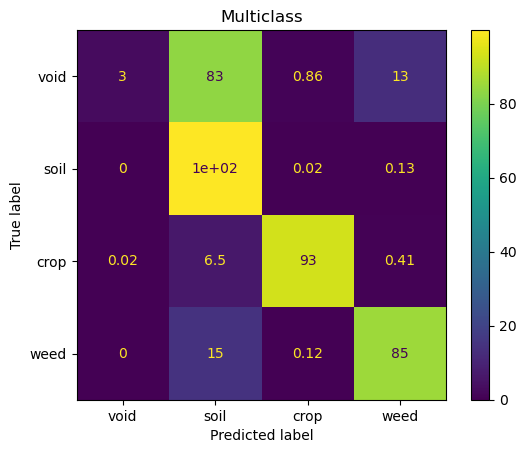

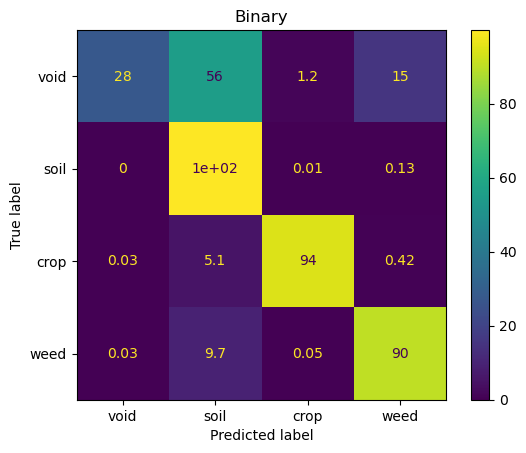

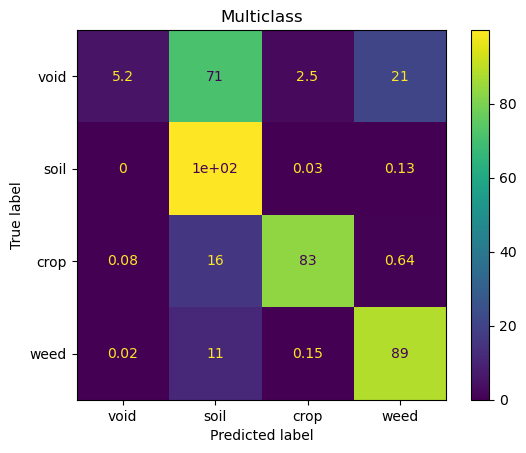

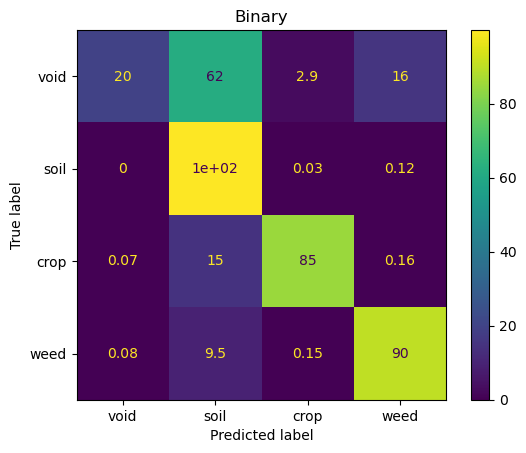

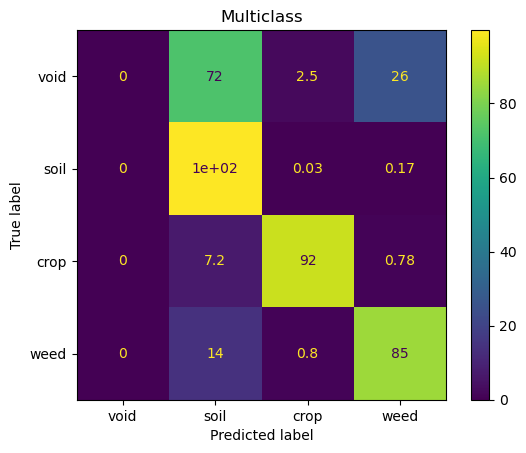

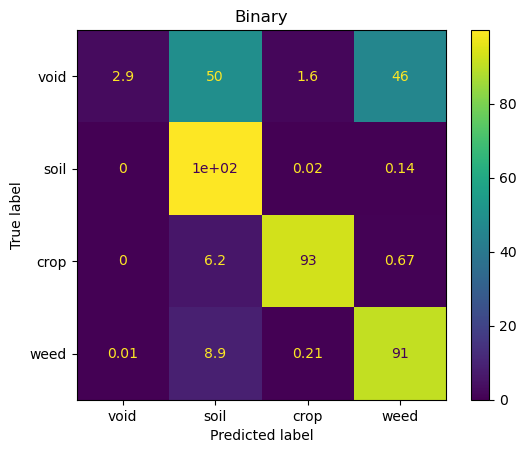

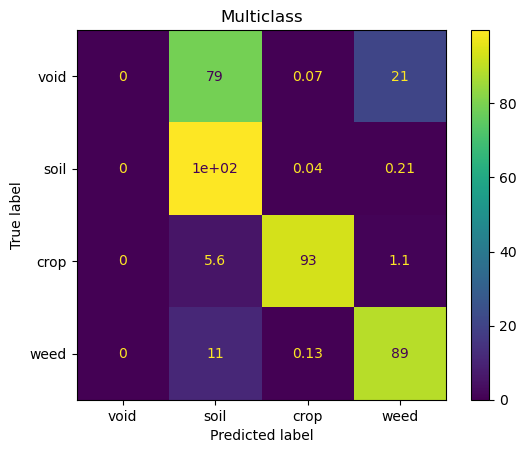

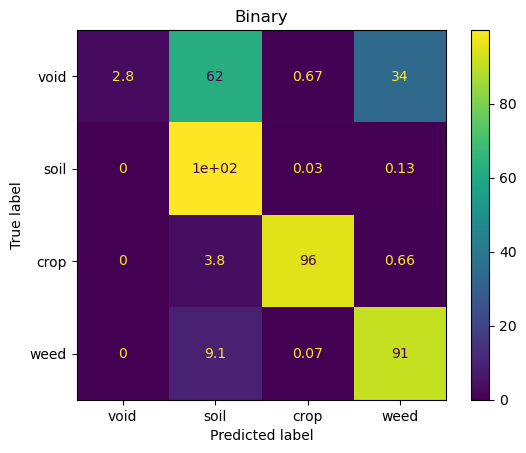

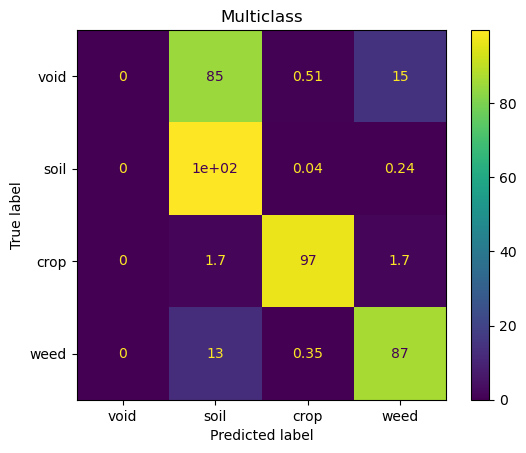

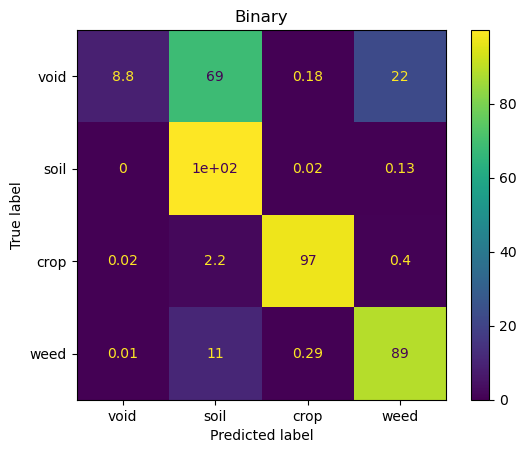

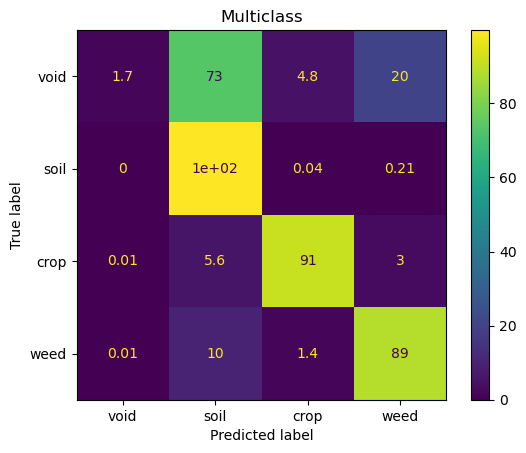

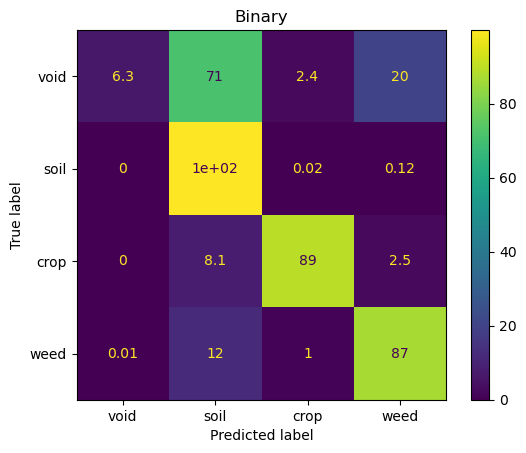

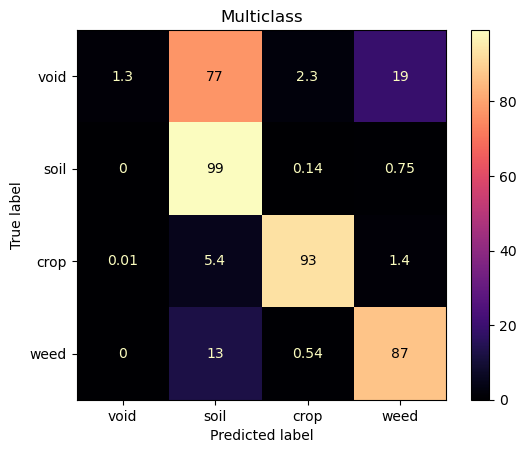

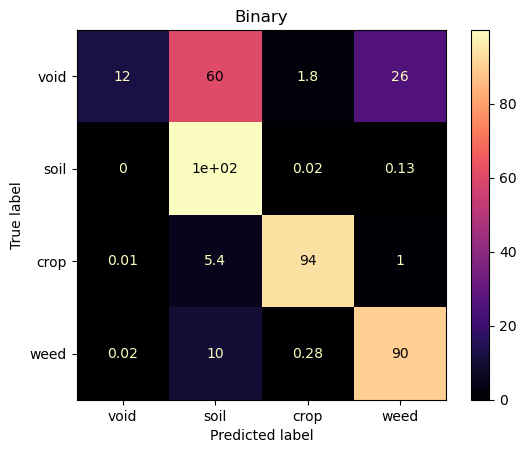

In [53]:
compute_and_visualize_confusion_matrices("../confusion_matrices/upernet-swin-models-3-patience/")

Crop: broad_bean
Multiclass absolute confusion matrix: 
[[    19339    120246      7615     37766]
 [     9002 766269773    181725   1303263]
 [      443     72001   4125534     21343]
 [     5167   1071744      6515  10159724]]
Binary absolute confusion matrix: 
[[    31717    110340      8063     34846]
 [    13671 766753442    112781    883869]
 [      584    105993   4087138     25606]
 [     3169   1091530      2788  10145663]]
Multiclass percentage confusion matrix: 
[[10.46 65.01  4.12 20.42]
 [ 0.   99.81  0.02  0.17]
 [ 0.01  1.71 97.78  0.51]
 [ 0.05  9.53  0.06 90.36]]
Binary percentage confusion matrix: 
[[17.15 59.65  4.36 18.84]
 [ 0.   99.87  0.01  0.12]
 [ 0.01  2.51 96.87  0.61]
 [ 0.03  9.71  0.02 90.24]]
Crop: common_buckwheat
Multiclass absolute confusion matrix: 
[[    45799    120112      2759     28825]
 [    32486 702304486    221534   1134827]
 [     5548     78241   2294191      2594]
 [    11411   1100711       734  10132542]]
Binary absolute confusion matrix

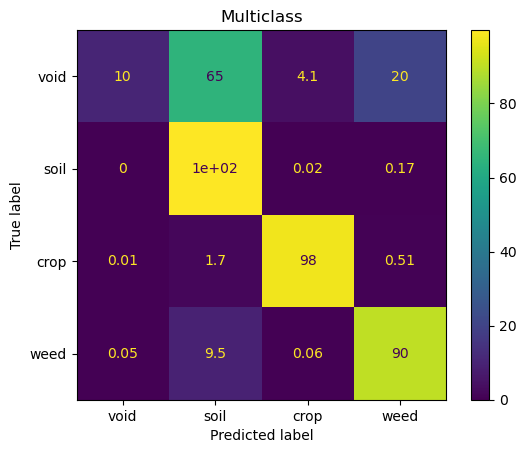

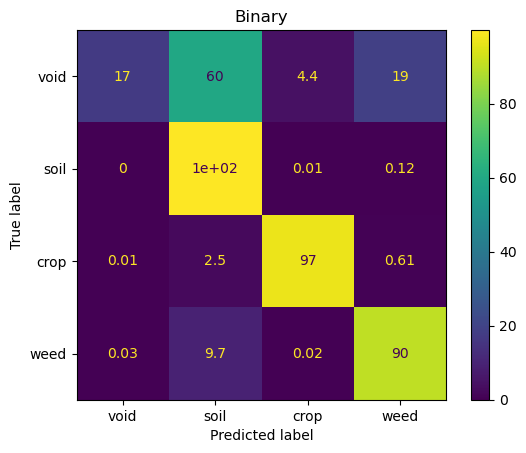

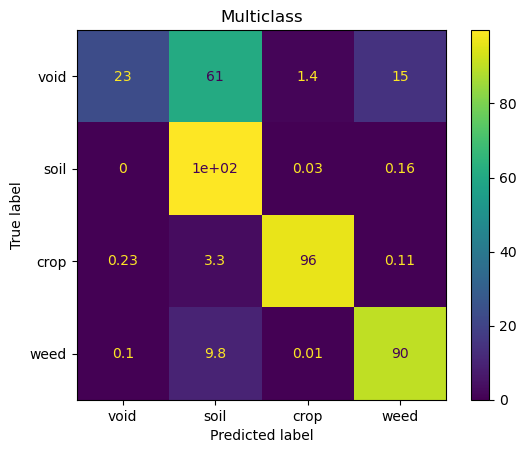

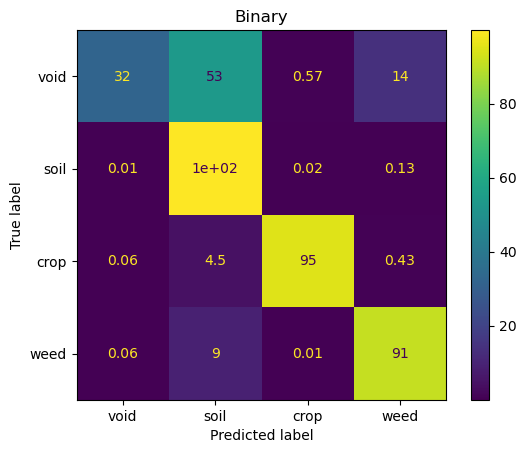

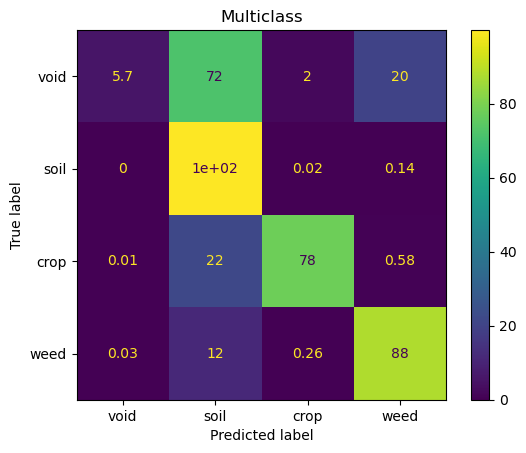

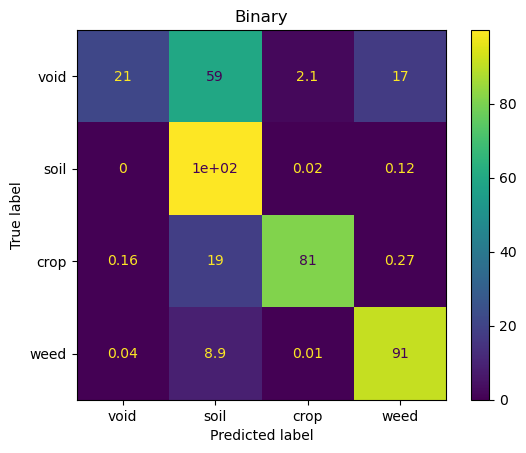

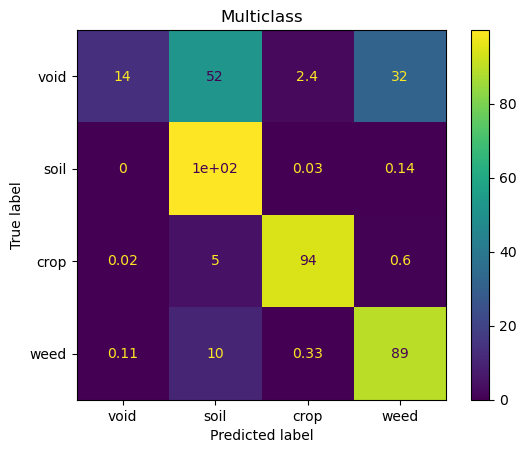

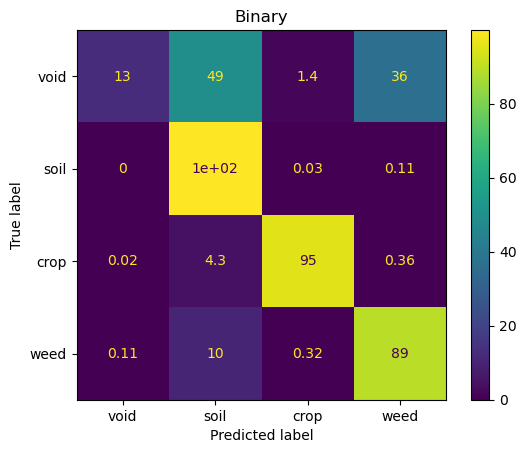

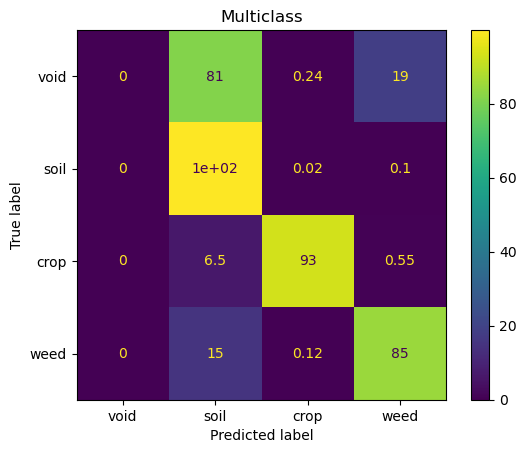

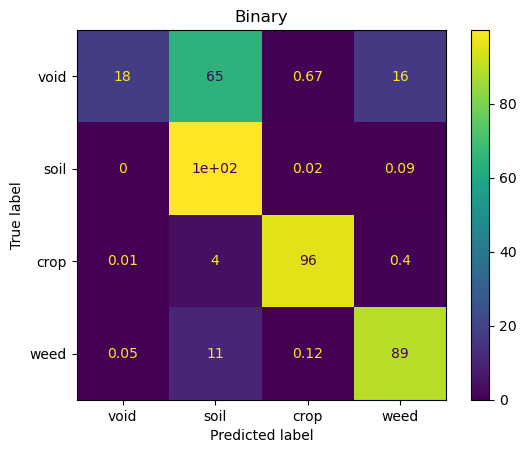

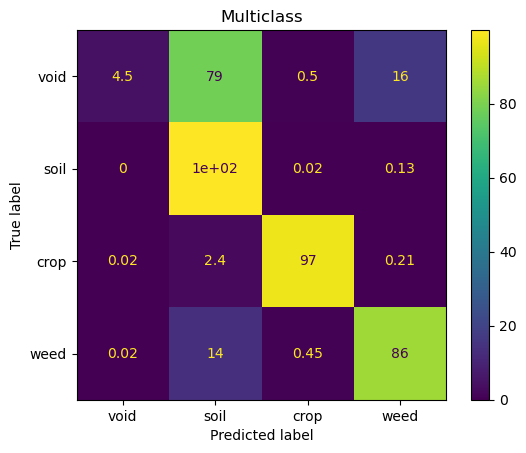

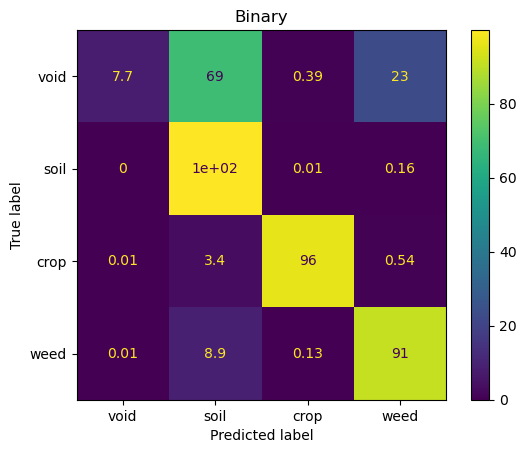

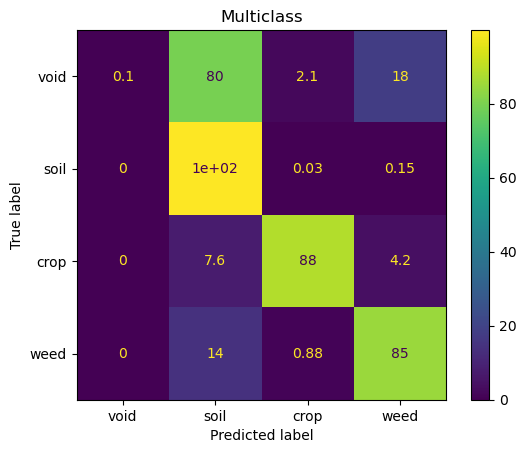

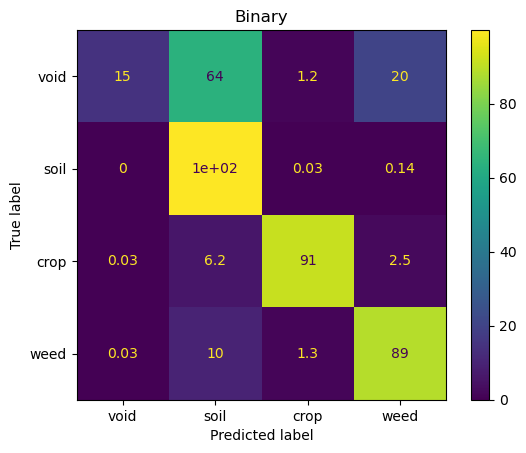

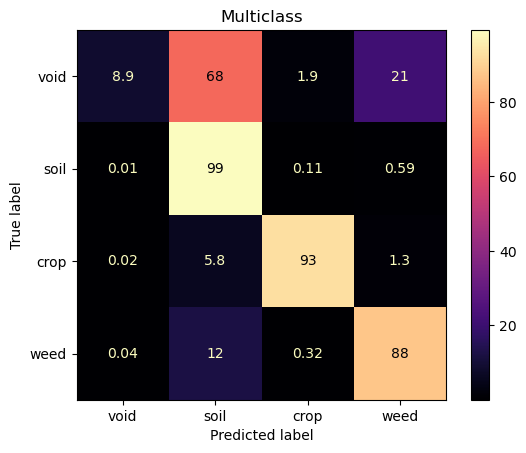

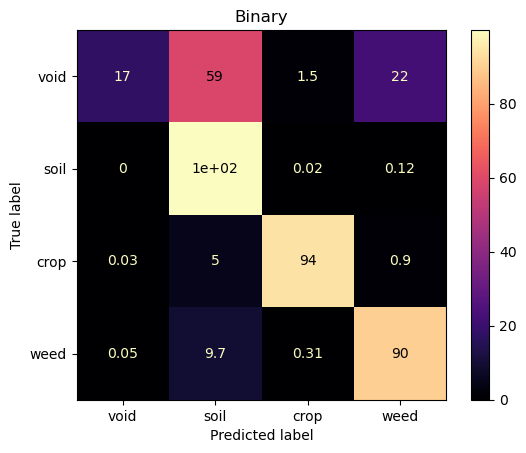

In [54]:
compute_and_visualize_confusion_matrices("../confusion_matrices/upernet-swin-models-5-patience/")